In [1]:
# Setup the library
import pyrogue as pr
import h5py
import os, sys
import matplotlib.pyplot as plt
import time
import numpy as np
import math

top_level=f'{os.getcwd()}/../../'
pr.addLibraryPath( f'{top_level}/scripts' )
import setupLibPaths
import epix_hr_single_10k
import ePixViewer.Cameras as cameras
     
#constants
ACQUIRE_C = False
#STEP OF 1 IS PREFFERED FOR MISSING CODE IDENTIFICATION, INL, DNL
#STEP OF 10 IS PREFFERED FOR DYNAMIC RANGE
CONVERT_C = False
ANALYSE_C = True

filename_root = '/u2/ddoering/ASIC_V4_ASIC2_SB_SET_ADC_0/'
filename_root = '/u2/ddoering/DET_HO1_V4_ASIC2_RUN_SET_1/'
initSequence = 5



Helper Functions

In [2]:
MAX_NUMBER_OF_FRAMES_PER_BATCH  = 1000
cameraType            = 'ePixHr10kT'
bitMask               = 0xffff
currentCam = cameras.Camera(cameraType = cameraType)
currentCam.bitMask = bitMask

def getData(localFile):

    file_header = [0]
    numberOfFrames = 0
    previousSize = 0
    while ((len(file_header)>0) and ((numberOfFrames<MAX_NUMBER_OF_FRAMES_PER_BATCH) or (MAX_NUMBER_OF_FRAMES_PER_BATCH==-1))):
        try:
            # reads file header [the number of bytes to read, EVIO]
            file_header = np.fromfile(localFile, dtype='uint32', count=2)
            payloadSize = int(file_header[0]/2)-2 #-1 is need because size info includes the second word from the header
            newPayload = np.fromfile(f, dtype='uint16', count=payloadSize) #(frame size splited by four to read 32 bit 
            #save only serial data frames
            if (numberOfFrames == 0):
                allFrames = [newPayload.copy()]
            else:
                newFrame  = [newPayload.copy()]
                allFrames = np.append(allFrames, newFrame, axis = 0)
            numberOfFrames = numberOfFrames + 1 
            #print ("Payload" , numberOfFrames, ":",  (newPayload[0:5]))
            previousSize = file_header
       
            if (numberOfFrames%1000==0):
                print("Read %d frames" % numberOfFrames)

        except Exception: 
            e = sys.exc_info()[0]
            #print ("Message\n", e)
            print ('\r', 'numberOfFrames read:', numberOfFrames, 'Size Error, currnt size', file_header, 'previous size', previousSize)
            

    return allFrames

def getDescImaData(localAllFrames):
##################################################
# image descrambling
##################################################
    numberOfFrames = localAllFrames.shape[0]
    currentCam = cameras.Camera(cameraType = cameraType)
    currentCam.bitMask = bitMask
#numberOfFrames = allFrames.shape[0]
    print("numberOfFrames in the 3D array: " ,numberOfFrames)
    print("Starting descrambling images")
    currentRawData = []
    imgDesc = []
    if(numberOfFrames==1):
        [frameComplete, readyForDisplay, rawImgFrame] = currentCam.buildImageFrame(currentRawData = [], newRawData = allFrames[0])
        imgDesc = np.array([currentCam.descrambleImage(bytearray(rawImgFrame.tobytes()))])
    else:
        for i in range(0, numberOfFrames):
        #get an specific frame
            [frameComplete, readyForDisplay, rawImgFrame] = currentCam.buildImageFrame(currentRawData, newRawData = localAllFrames[i,:])
            currentRawData = rawImgFrame

        #get descrambled image from camera
            if (len(imgDesc)==0 and (readyForDisplay)):
                imgDesc = np.array([currentCam.descrambleImage(bytearray(rawImgFrame.tobytes()))])
                currentRawData = []
            else:
                if readyForDisplay:
                    currentRawData = []
                    newImage = np.array([currentCam.descrambleImage(bytearray(rawImgFrame.tobytes()))])
                #newImage = currentCam.descrambleImage(rawImgFrame)
                #newImage = newImage.astype(np.float, copy=False)
                #if (np.sum(np.sum(newImage))==0):
                #    newImage[np.where(newImage==0)]=np.nan
                    imgDesc = np.concatenate((imgDesc, np.array([newImage[0]])),0)

    return imgDesc

def printname(name):
    print (name)

def setPixel (Preamp = 4, Vld1_b = 1, Pixel_CB = 4, Filter_DAC = 38, VRef_DAC = 53):
    ASIC.Preamp.set(Preamp)
    ASIC.Vld1_b.set(Vld1_b)
    ASIC.Pixel_CB.set(Pixel_CB)
    ASIC.Filter_DAC.set(Filter_DAC)
    ASIC.VRef_DAC.set(VRef_DAC)


    print('Preamp', ASIC.Preamp.get())
    print('Vld1_b',ASIC.Vld1_b.get())
    print('Pixel_CB',ASIC.Pixel_CB.get())
    print('Filter_DAC',ASIC.Filter_DAC.get())
    print('VRef_DAC',ASIC.VRef_DAC.get())
    
def setADC (RefGenB = 3, RefGenC = 2, S2D_1_b = 0, shvc_DAC = 23, S2dDacBias = 3):
    print('Original values')
    print('RefGenB', ASIC.RefGenB.get())
    print('RefGenC',ASIC.RefGenC.get())
    print('S2D_1_b',ASIC.S2D_1_b.get())
    print('shvc_DAC',ASIC.shvc_DAC.get())
    print('S2dDacBias',ASIC.S2dDacBias.get())
    
    ASIC.RefGenB.set(RefGenB) #2 bits
    ASIC.RefGenC.set(RefGenC) #2 bits
    ASIC.S2D_1_b.set(S2D_1_b) #3 bits
    ASIC.shvc_DAC.set(shvc_DAC) #6 bits
    ASIC.S2dDacBias.set(S2dDacBias)
    
    print('New values')
    print('RefGenB', ASIC.RefGenB.get())
    print('RefGenC',ASIC.RefGenC.get())
    print('S2D_1_b',ASIC.S2D_1_b.get())
    print('shvc_DAC',ASIC.shvc_DAC.get())
    print('S2dDacBias',ASIC.S2dDacBias.get())
    
def readPixelConfig(ASIC, x, y):
    ASIC.CmdPrepForRead() #0000
    ASIC.PrepareMultiConfig() #8000
    bankToWrite = int(y/48);
    if (bankToWrite == 0):
     colToWrite = 0x700 + y%48;
    elif (bankToWrite == 1):
     colToWrite = 0x680 + y%48;
    elif (bankToWrite == 2):
     colToWrite = 0x580 + y%48;
    elif (bankToWrite == 3):
     colToWrite = 0x380 + y%48;
    else:
     print('unexpected bank number')
    ASIC.RowCounter.set(x) #6011
    ASIC.ColCounter.set(colToWrite) #6013
    readBack = ASIC.WritePixelData.get() #5000
    ASIC.CmdPrepForRead() #0000
    return readBack

def writedPixelConfig(ASIC, x, y, value):
    ASIC.CmdPrepForRead() #0000
    ASIC.PrepareMultiConfig() #8000
    bankToWrite = int(y/48);
    if (bankToWrite == 0):
     colToWrite = 0x700 + y%48;
    elif (bankToWrite == 1):
     colToWrite = 0x680 + y%48;
    elif (bankToWrite == 2):
     colToWrite = 0x580 + y%48;
    elif (bankToWrite == 3):
     colToWrite = 0x380 + y%48;
    else:
     print('unexpected bank number')
    ASIC.RowCounter.set(x) #6011
    ASIC.ColCounter.set(colToWrite) #6013
    readBack = ASIC.WritePixelData.set(value) #5000
    ASIC.CmdPrepForRead() #0000
    return readBack

def runDataAquistion(filename):
    #sets ASIC to point to the external DAC
    ASIC.mTest.set(True)
     #Makes sure triggers are off
    root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
    root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
    time.sleep(10)
    root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
    time.sleep(0.1)

    #use system with batcher and missing ASICs
    root.EpixHR.SspLowSpeedDecoderReg.enable.set(True)
    print ("Locked lanes: %x" % root.EpixHR.SspLowSpeedDecoderReg.Locked.get())
    
    root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)

    #sets HSDAC device
    root.EpixHR.HSDac.enable.set(True)
    #reset status
    root.EpixHR.HSDac.WFEnabled.set(False)
    root.EpixHR.HSDac.waveformSource.set(0)
    root.EpixHR.HSDac.externalUpdateEn.set(False)
    root.EpixHR.HSDac.run.set(False)

    #configure
    root.EpixHR.HSDac.rCStartValue.set(0)
    root.EpixHR.HSDac.rCStopValue.set(65535)
    root.EpixHR.HSDac.rCStep.set(SCAN_STEP_C)
    root.EpixHR.HSDac.WFEnabled.set(True)
    root.EpixHR.HSDac.waveformSource.set(1)
    root.EpixHR.HSDac.externalUpdateEn.set(True)
    root.EpixHR.HSDac.run.set(True)

    # Remove previous dataset
    #if os.path.isfile(f'{top_level}/test.dat'):
    #    os.remove(f'{top_level}/test.dat')    
    if os.path.isfile(f'{filename}'):
        os.remove(f'{filename}')    


    # Setup and open the file writer
    writer = root.dataWriter._writer
    writer.open(f'{filename}')

    # Wait for the file write to open the file
    while( writer.isOpen() is False):
        time.sleep(0.1)

    # Wait a little bit for the file to open up
    time.sleep(1.0)    

    #sets TriggerRegisters
    AcqCount = root.EpixHR.TriggerRegisters.AcqCount.get()
    print("Aquisition Counter " + str(AcqCount))
    root.EpixHR.TriggerRegisters.AutoTrigPeriod.set(100000) #in steps of 10ns
    root.EpixHR.TriggerRegisters.AutoRunEn.set(True)
    root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
    #wait for the camera to get thermally stable
    time.sleep(5.0)    
    root.EpixHR.TriggerRegisters.AutoDaqEn.set(True)
    root.EpixHR.TriggerRegisters.DaqTriggerEnable.set(True)
    initialFrameCounter = writer.getFrameCount()

    # Wait for the file write to write the 10 waveforms
    while(writer.getFrameCount() < int(65535/SCAN_STEP_C)):
        print( f'Number of frames received: {writer.getFrameCount()}' )
        time.sleep(1)

    # stops triggers
    root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
    time.sleep(0.1)

    # Print the status
    DeltaAcqCount = root.EpixHR.TriggerRegisters.AcqCount.get() - AcqCount
    print( f'Delta Aquisition Counter: {DeltaAcqCount}')
    print( f'Number of frames received: {writer.getFrameCount()}' )

    # Close the file writer
    writer.close()

    # Wait for the file write to close the file
    while( writer.isOpen() is True):
        time.sleep(0.1)

        
def convertData(filename):
    from importlib import reload
    reload(cameras)
    
    h5_filename = os.path.splitext(filename)[0]+".hdf5"
    
    if os.path.isfile(f'{h5_filename}'):
        os.remove(f'{h5_filename}')    

    MAX_NUMBER_OF_FRAMES_PER_BATCH  = 1000
    cameraType            = 'ePixHr10kTBatcher'
    bitMask               = 0xffff
    currentCam = cameras.Camera(cameraType = cameraType)
    currentCam.bitMask = bitMask
    currentCam.MAX_NUMBER_OF_FRAMES_PER_BATCH  = MAX_NUMBER_OF_FRAMES_PER_BATCH

    f = open(filename, mode = 'rb')
    imgDesc = []
    for i in range(round(66/SCAN_STEP_C)):
        print("Starting to get data set %d" % (i))
        allFrames = currentCam.getData(f,8)
        imgDesc2 = currentCam.getDescImaData(allFrames)
        if i == 0:
            headers = allFrames[:,0:6]
            imgDesc = imgDesc2
        else:
            headers = np.concatenate((headers, allFrames[:,0:6]),0)
            imgDesc = np.concatenate((imgDesc, imgDesc2),0)
        if allFrames.shape[0] != MAX_NUMBER_OF_FRAMES_PER_BATCH:
            break


    #numberOfFrames = allFrames.shape[0]
    print("Saving Hdf5")       
    f = h5py.File(h5_filename, "w")
    for i in range(0,6):
        f['header_%d'%i] = headers[:,i]
    f['adcData'] = imgDesc.astype('uint16')
    f.close()



Camera  ePixHr10kT  selected.


In [3]:
if CONVERT_C :
    
    Preamp = 4
    Vld1_b = 1
    Pixel_CB= 4
    Filter_DAC= 38
    VRef_DAC = 53    
    
    DHg = False
    RefGenBList = [2]
    RefGenC = 3
    S2D_1_b = 0
    shvc_DAC = 23
    S2dDacBias = 3
    for RefGenB in RefGenBList:
        #setADC (RefGenB, RefGenC, S2D_1_b, shvc_DAC, S2dDacBias)
        ######################################################################################################################
        filename = (filename_root + f'ePixHR10kT_ASIC2_V4_externalRamp_320MHz_ScanStep_10_initSequence_%d_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_DHg_%d_RefGenB_%d_RefGenC_%d_run1.dat' % (initSequence, Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC,DHg,RefGenB,RefGenC))
        print(filename)
        ########################################################################################################################         
        convertData(filename)

In [4]:
def externalRampTest_analyses_sept1(h5_filename):
    dfile = h5py.File(h5_filename, 'r')
    #dfile.visit(printname)
    
    imgDesc = dfile['/adcData']
    
    #for i in range(0,6):
    #    headers[:,i] = dfile['header_%d'%i]
    
    
    print(imgDesc.shape)
    plt.figure(figsize=(6,4),dpi=150)
    plt.imshow(imgDesc[1000])
    plt.title(h5_filename)
    plt.figure(figsize=(6,4),dpi=150)
    maxRange = imgDesc.shape[0] if (imgDesc.shape[0] < int(65000/SCAN_STEP_C))  else int(65000/SCAN_STEP_C)
    for imgIdx in np.arange(0, maxRange,int(2000/SCAN_STEP_C )):
        plt.plot(imgDesc[imgIdx,20,:])
        plt.title(h5_filename)
    return imgDesc, maxRange

In [5]:
def externalRampTest_analyses_sept2():
    plt.figure(figsize=(5,3),dpi=150)
    for column in np.arange(384):
        plt.plot(np.linspace(0, maxRange, maxRange), imgDesc[0:maxRange,10, column], linewidth=4)
    plt.xlabel('DAC [sample]')
    plt.ylabel('ADC value [ADU]')
    plt.show()

In [6]:
def externalRampTest_analyses_sept3():
    fig, axs = plt.subplots(3,2,figsize=(12,8),dpi=150)
    fig.suptitle('Ramps by bank')
    spNum = [0, 0]
    for startCol in np.arange(192*0,192+192*0,32):
        for column in np.arange(startCol,startCol+32):
            axs[spNum[0],spNum[1]].plot(np.linspace(0, maxRange, maxRange), imgDesc[0:maxRange,10, column], linewidth=4)
        spNum[0] += 1
        if spNum[0] == 3:
            spNum[0] = 0
            spNum[1] += 1
        
        print(spNum)
        #plt.xlabel('DAC [sample]')
        #plt.ylabel('ADC value [ADU]')
    plt.show()
        


In [7]:
def externalRampTest_analyses_sept4():
    CHANNEL_INDEX_CTE = np.arange(192*0,192+192*0,16)
    BANK_C = 2
    CHANNEL_INDEX_CTE = np.arange(192*0+32*BANK_C,192*0+32*BANK_C+32,1)
    linearStartRange = int(25000/SCAN_STEP_C)
    linearEndRange = int(55000/SCAN_STEP_C)
    row = 10
    figureIndex = 0
    for column in CHANNEL_INDEX_CTE:
        fig, axs = plt.subplots(1,2,figsize=(12,4),dpi=150)
        reducedDataSubset = imgDesc[linearStartRange:linearEndRange,row,column]
        #print(reducedDataSubset.shape)

        #from scipy import signal
        y = np.arange(0,reducedDataSubset.shape[0])#linearStartRange, linearEndRange)[0:65535:11]
        #x = signal.resample(avgdataSubset, 65536)
        x = reducedDataSubset

        #[x>2047] = y[x>2047] + MID_SCALE_CORR_CTE

        #print('Shape downsampled' , x.shape)
        startIndex = int(2000/SCAN_STEP_C)
        stopIndex = reducedDataSubset.shape[0]-(int(2000/SCAN_STEP_C))

        z = np.polyfit(x[startIndex:stopIndex], y[startIndex:stopIndex], 1)
        f = np.poly1d(z)
        #print("Fitting parameters for ADC Channel [%d]" %(column))
        #print(f)

        x_est = x
        y_est = f(x_est)

        #plt.figure(1,figsize=(12,8),dpi=150)
        #axs[0].title('ADC levels for average samples')
        #axs[0].ylabel('N [sample]')
        #axs[0].xlabel('ADC value [ADU]')
        axs[0].plot(x, y, 'o', x_est, y_est, linewidth=4)
        #axs[0].legend([f'ADC data {column}', 'Linear Fit'])
        #axs[0].show()

        x_diff = x
        y_diff = (y - y_est)

        #print("limits are [%d, %d]" % (x_diff[startIndex],x_diff[stopIndex]))
        figureIndex += 0
        #plt.figure(1,figsize=(12,8),dpi=150)
        #axs[1].plt.rc('xtick', labelsize=14) 
        #plt.rc('ytick', labelsize=14) 
        #plt.title('ADC level difference to linear fit')
        #axs[1].ylabel('INL Linear Fit Residuals [ADC]', fontsize=20)
        #axs[1].xlabel('ADC Value', fontsize=20)
        axs[1].plot(x_diff, y_diff, linewidth=1)
        axs[1].plot(x_diff[startIndex:stopIndex], y_diff[startIndex:stopIndex], 'r', linewidth=1)
        #axs[1].ylim(-185,185)
        axs[1].axhline(5.0, color='black',linestyle='--') # cutoff frequency
        axs[1].axhline(-5.0, color='black',linestyle='--') # cutoff frequency
        #plt.savefig('cryoDiffLinearFit.png', dpi=300)
        #plt.savefig(os.path.splitext(filename)[0]+"corr_factor_"+ str(MID_SCALE_CORR_CTE) +"_channel_" + str(channelIndex) + "_figure_" + str(figureIndex) +".png")
        #axs[1].plt.show()
        MeasuredMadDevLinFit = np.max(np.abs(y_diff[startIndex:stopIndex]))
        #print('MeasuredMadDevLinFit', MeasuredMadDevLinFit)

In [8]:
def externalRampTest_analyses_sept5():
    CHANNEL_INDEX_CTE = np.arange(192*0,192+192*0,1)
    #BANK_C = 0
    #CHANNEL_INDEX_CTE = np.arange(192+32*BANK_C,192+32*BANK_C+32,1)
    linearStartRange = int(15000/SCAN_STEP_C)
    linearEndRange = int(65000/SCAN_STEP_C)
    row = 10
    figureIndex = 0
    loopIndex = 0
    gainList = np.zeros(CHANNEL_INDEX_CTE.shape[0])
    measuredMaxDevLinFit = np.zeros(CHANNEL_INDEX_CTE.shape[0])
    rangeList = np.zeros(CHANNEL_INDEX_CTE.shape[0])
    for column in CHANNEL_INDEX_CTE:
        
        rangeList[loopIndex] = np.max(imgDesc[linearStartRange:linearEndRange,row,column]) - np.min(imgDesc[linearStartRange:linearEndRange,row,column])
        
        reducedDataSubset = imgDesc[linearStartRange:linearEndRange,row,column]
        
        #from scipy import signal
        y = np.arange(0,reducedDataSubset.shape[0])#linearStartRange, linearEndRange)[0:65535:11]
        #x = signal.resample(avgdataSubset, 65536)
        x = reducedDataSubset

        #[x>2047] = y[x>2047] + MID_SCALE_CORR_CTE

        #print('Shape downsampled' , x.shape)
        startIndex = int(2000/SCAN_STEP_C)
        stopIndex = reducedDataSubset.shape[0]-(int(2000/SCAN_STEP_C))

        z = np.polyfit(x[startIndex:stopIndex], y[startIndex:stopIndex], 1)
        f = np.poly1d(z)
        gainList[loopIndex] = f[1]
        
        x_est = x
        y_est = f(x_est)


        x_diff = x
        y_diff = (y - y_est)

               

        measuredMaxDevLinFit[loopIndex] = np.max(np.abs(y_diff[startIndex:stopIndex]))
                
        loopIndex +=1
    
    return CHANNEL_INDEX_CTE, gainList, measuredMaxDevLinFit, rangeList
        


In [9]:
def externalRampTest_analyses_sept6():
    summary = []
    summary.append(CHANNEL_INDEX_CTE)
    summary.append(gainList)
    summary.append(measuredMaxDevLinFit)
    summary.append(rangeList)

    summary_np = np.asarray(summary)
    #print(summary_np.transpose())

    plt.figure(figsize=(5,3),dpi=150)
    plt.rc('xtick', labelsize=14) 
    plt.rc('ytick', labelsize=14) 
    #plt.title('ADC level difference to linear fit')
    plt.ylabel('ADC gain []', fontsize=20)
    plt.xlabel('ADC index', fontsize=20)
    plt.stem(CHANNEL_INDEX_CTE, np.abs(gainList))
    plt.show()

    plt.figure(figsize=(5,3),dpi=150)
    plt.rc('xtick', labelsize=14) 
    plt.rc('ytick', labelsize=14) 
    #plt.title('ADC level difference to linear fit')
    plt.ylabel('DNL Linear Fit Residuals [ADC]', fontsize=20)
    plt.xlabel('ADC index', fontsize=20)
    plt.stem(CHANNEL_INDEX_CTE, np.abs(measuredMaxDevLinFit))
    plt.show()

    plt.figure(figsize=(5,3),dpi=150)
    plt.rc('xtick', labelsize=14) 
    plt.rc('ytick', labelsize=14) 
    #plt.title('ADC level difference to linear fit')
    plt.ylabel('Dynamic range [ADU]', fontsize=20)
    plt.xlabel('ADC index', fontsize=20)
    plt.stem(CHANNEL_INDEX_CTE, np.abs(rangeList))
    plt.show()

(66000, 145, 384)


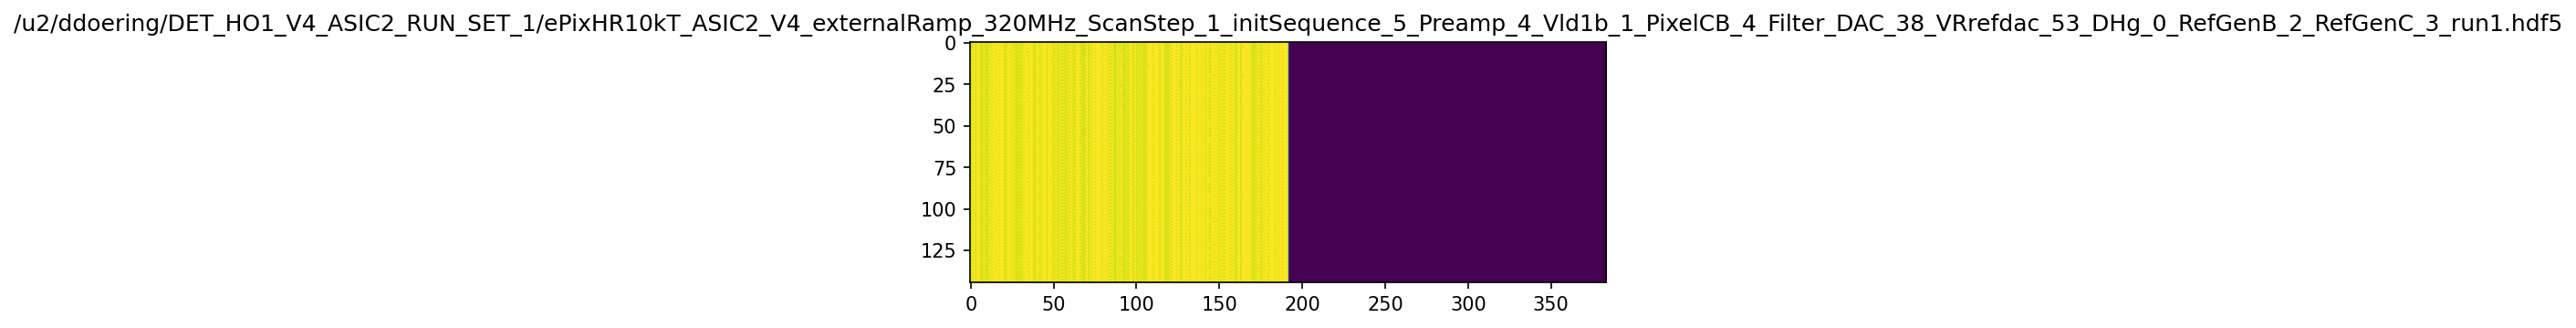

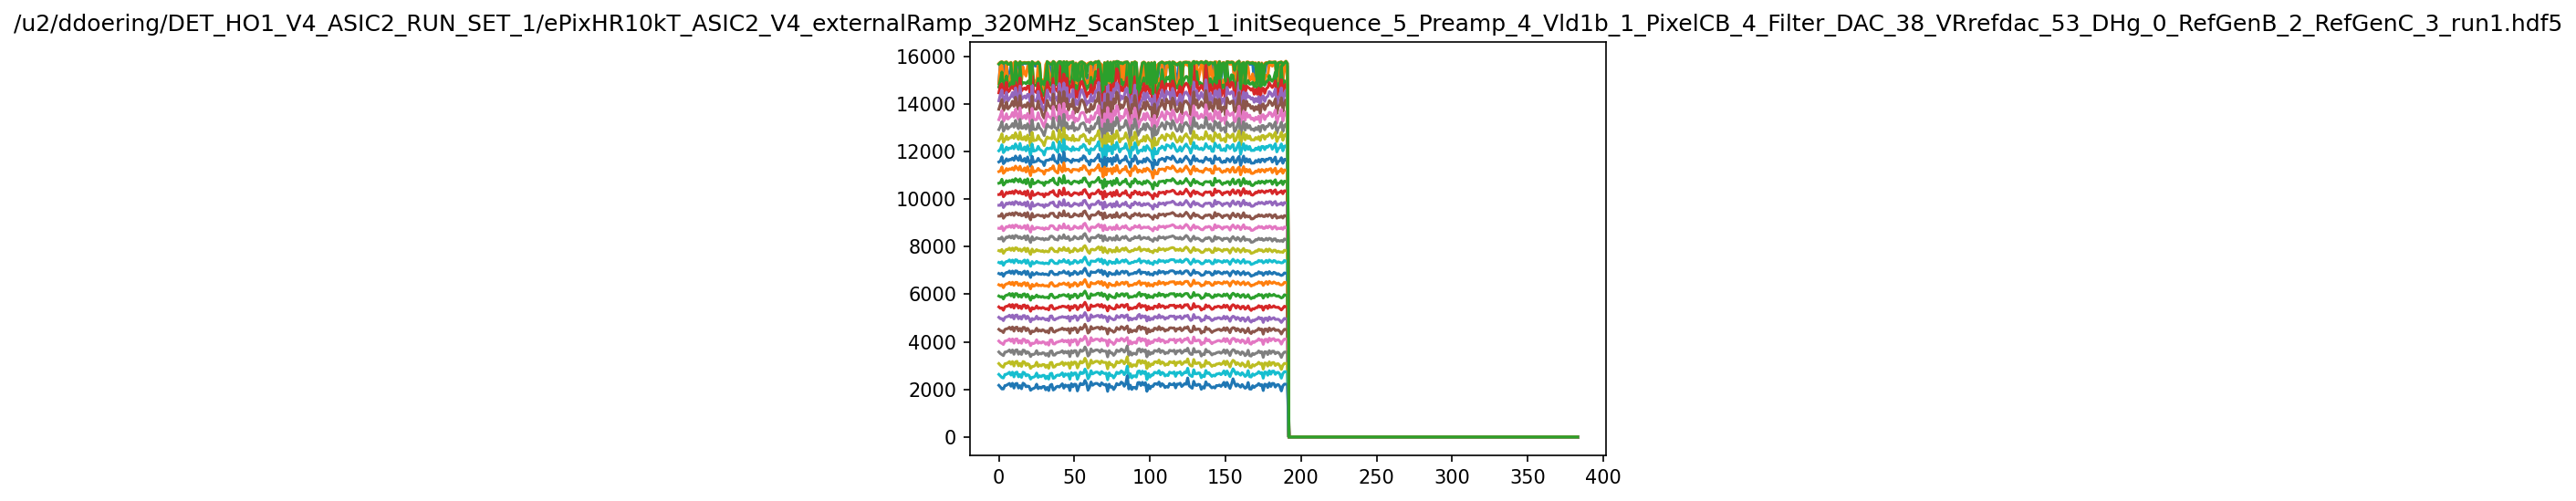

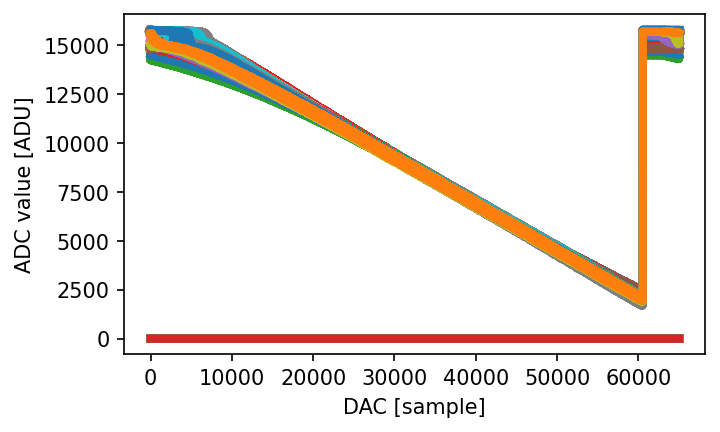

[1, 0]
[2, 0]
[0, 1]
[1, 1]
[2, 1]
[0, 2]


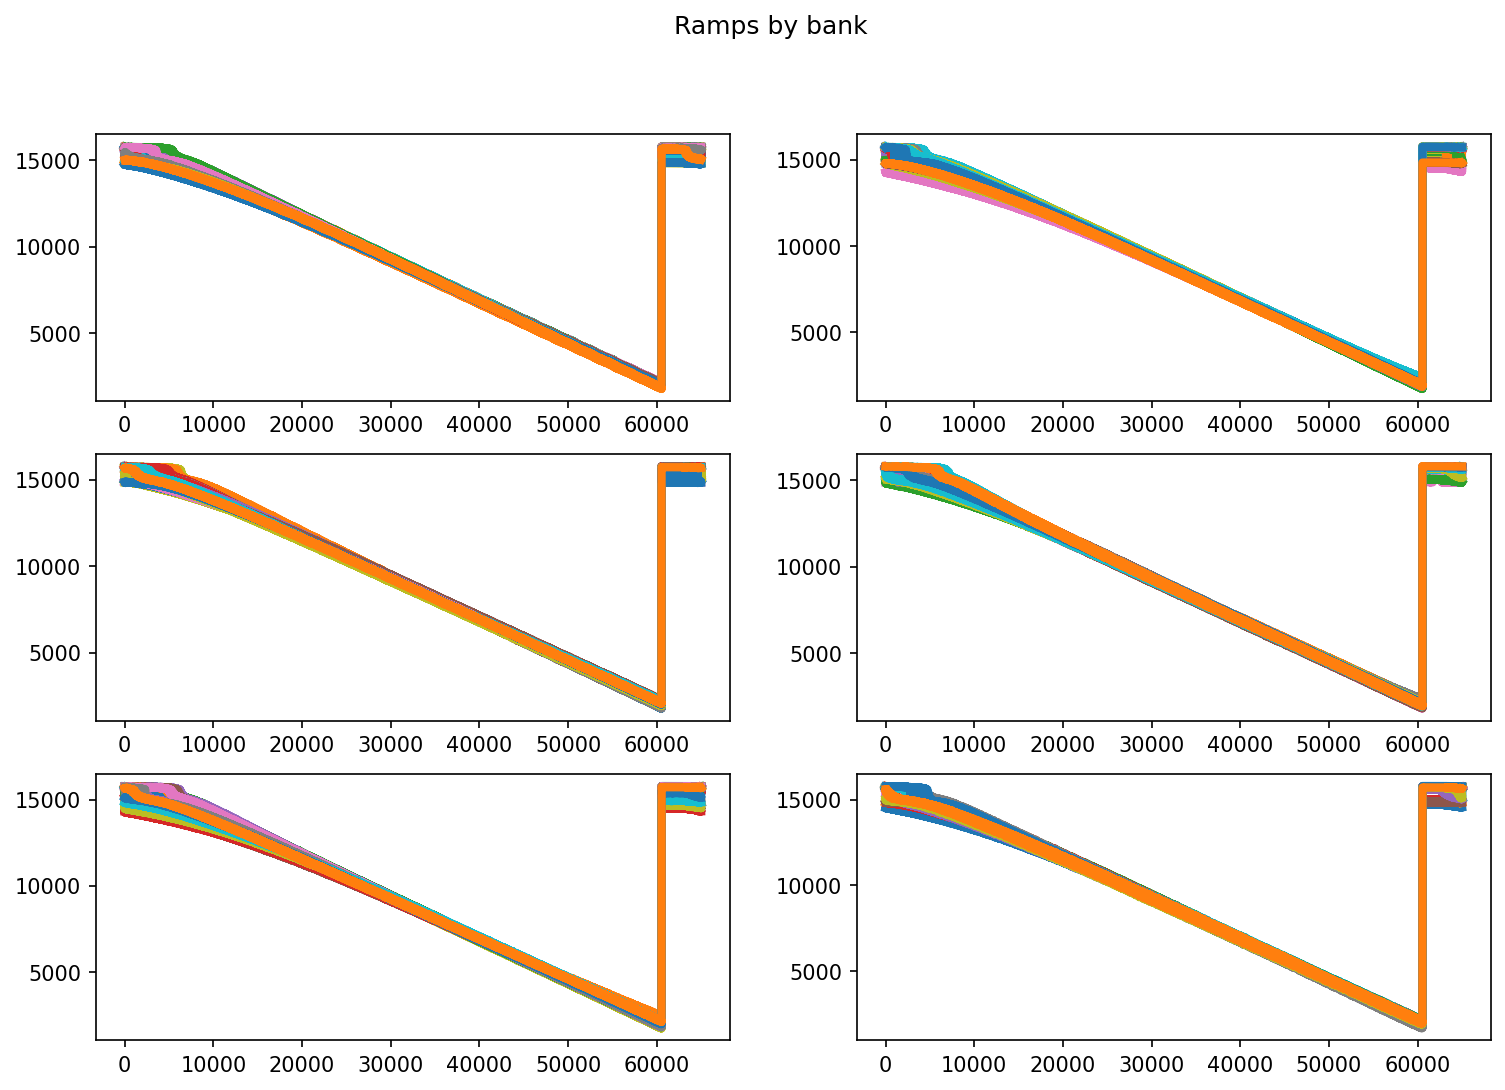

/tmp/ipykernel_3123/24376222.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1,2,figsize=(12,4),dpi=150)


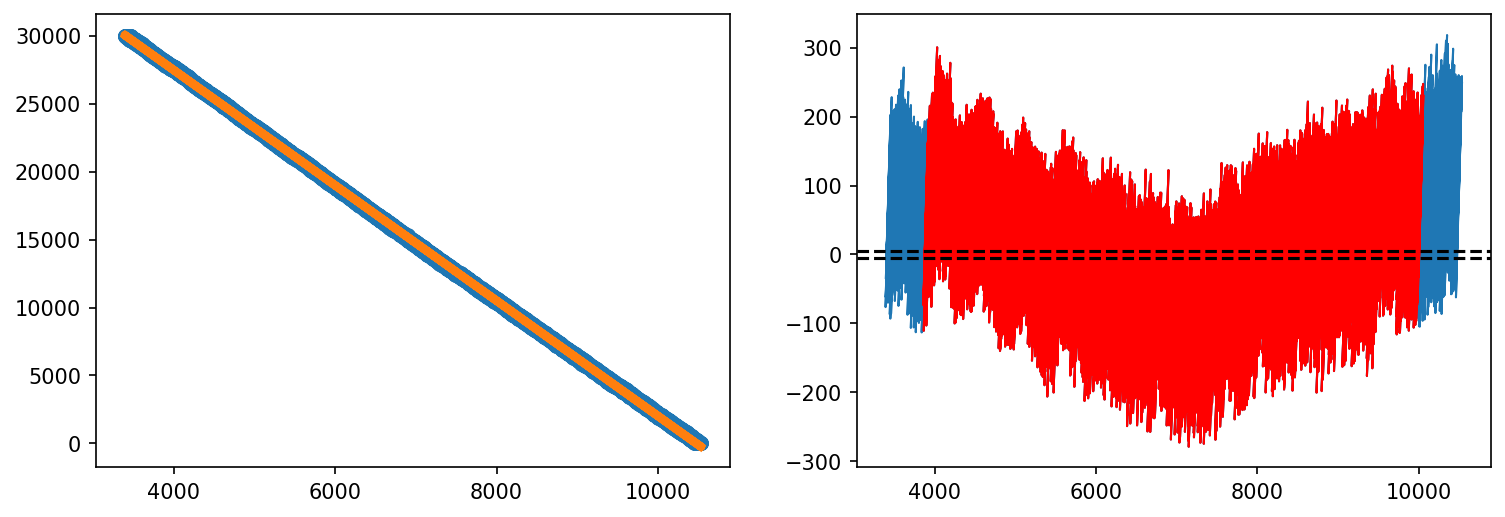

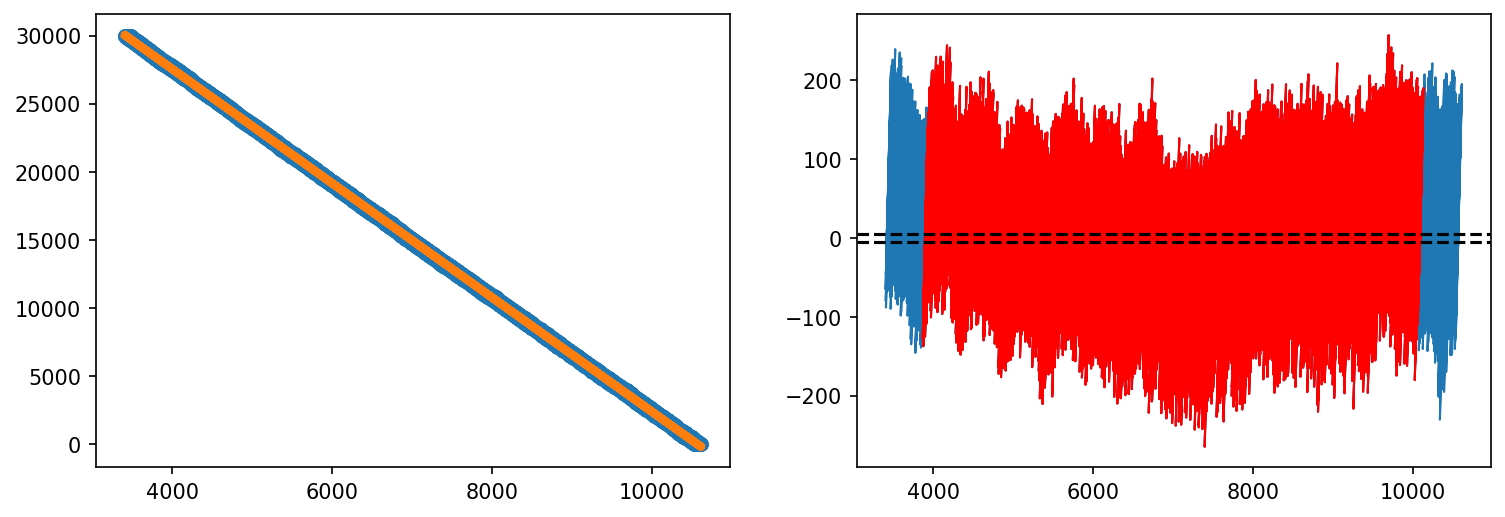

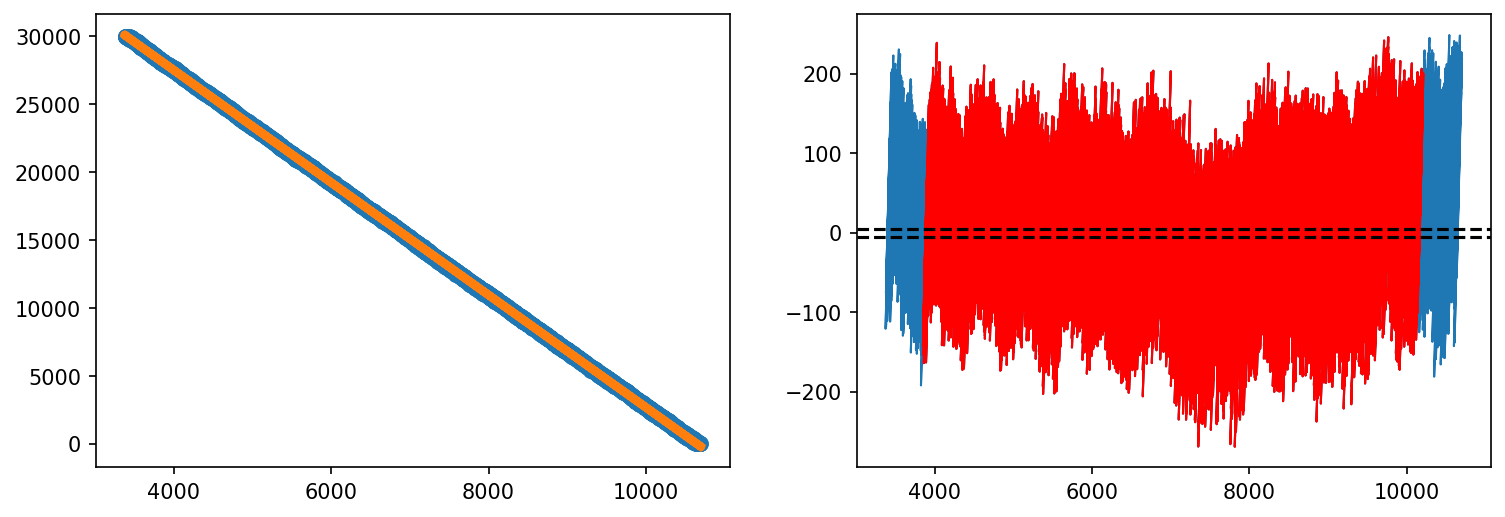

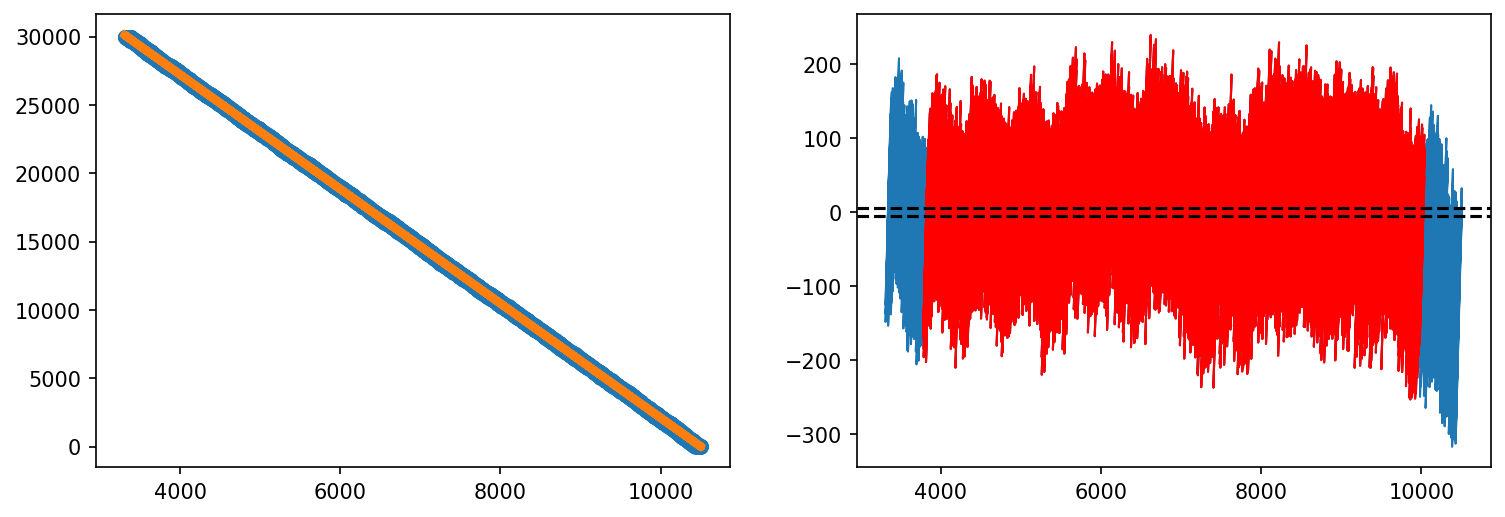

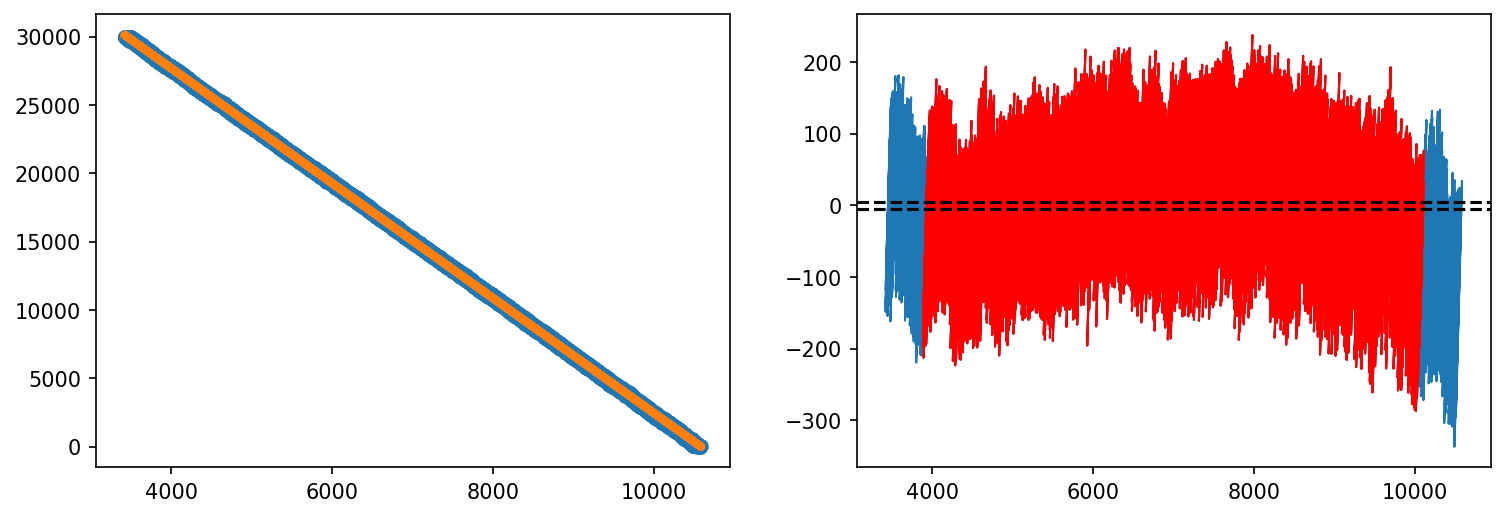

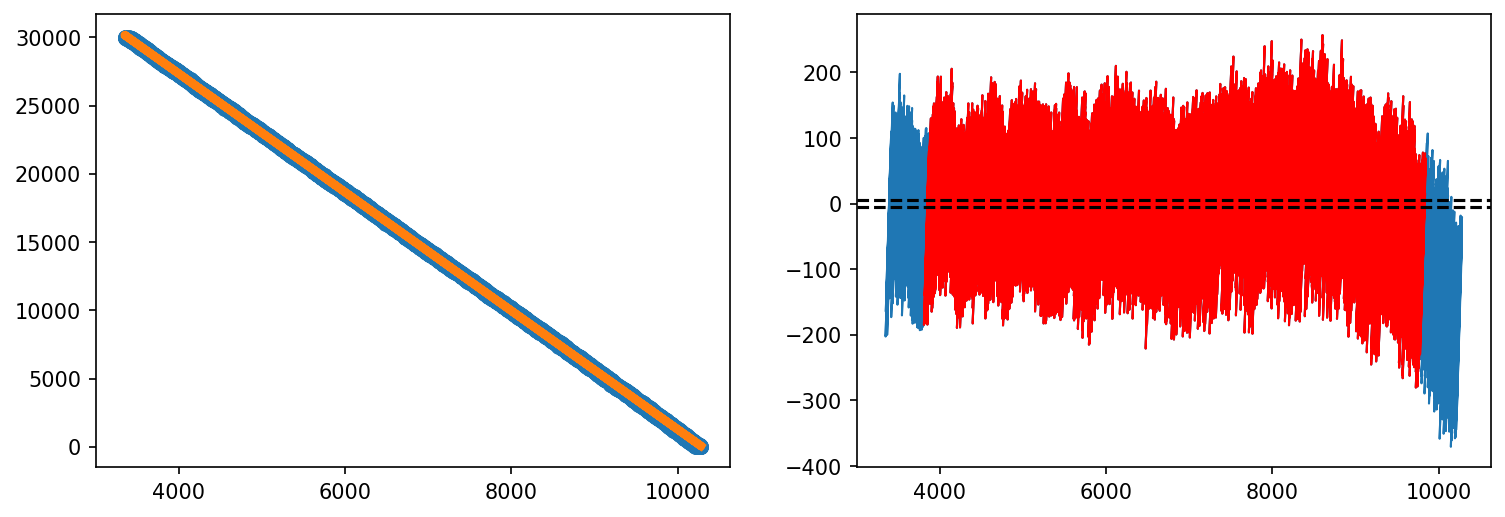

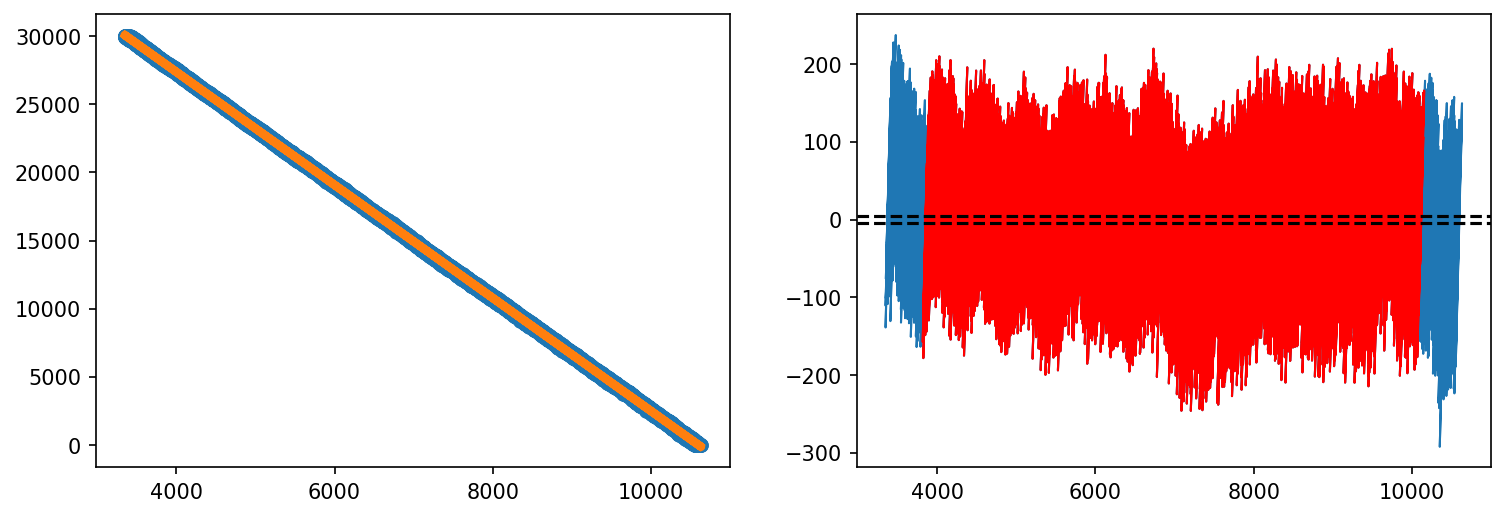

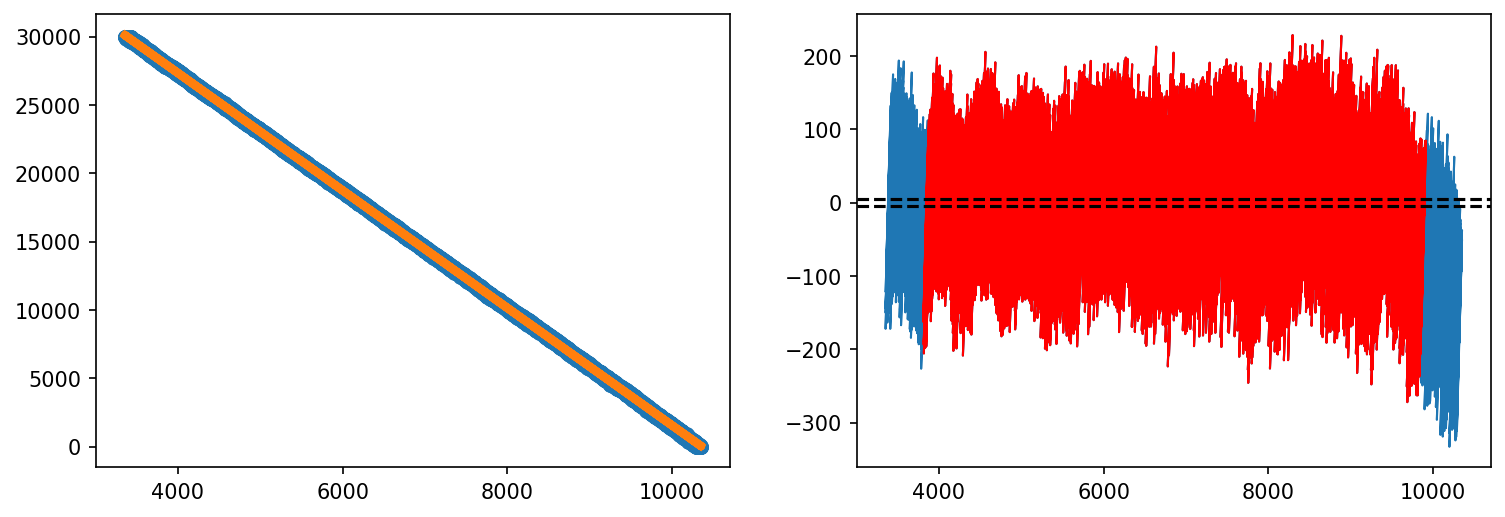

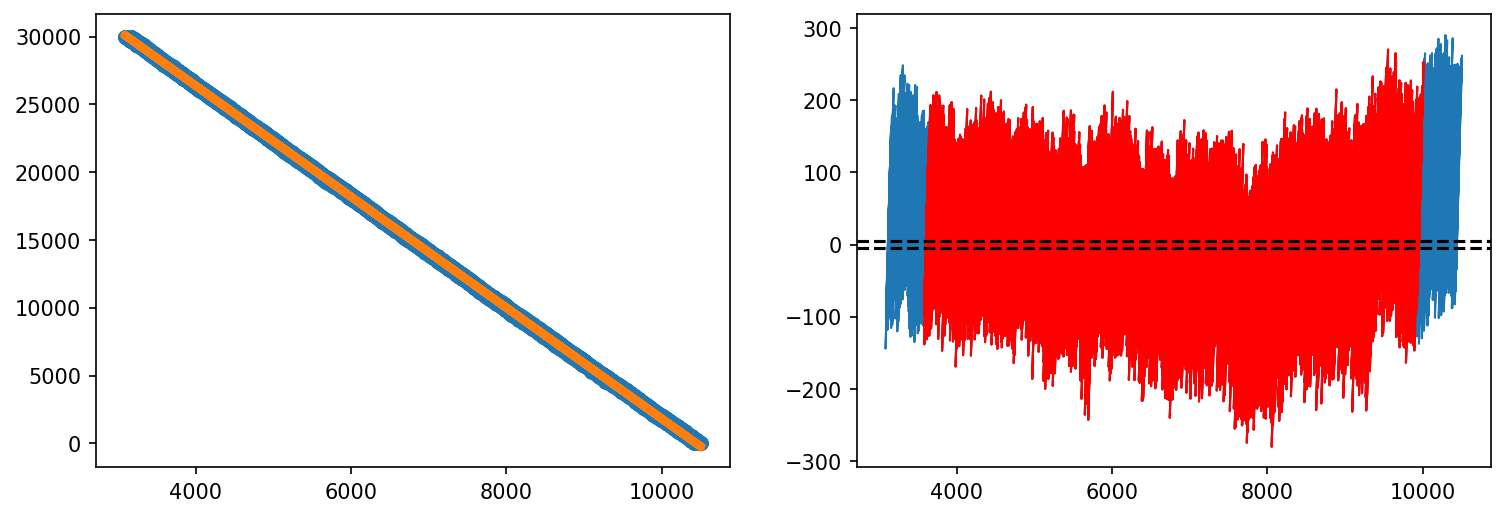

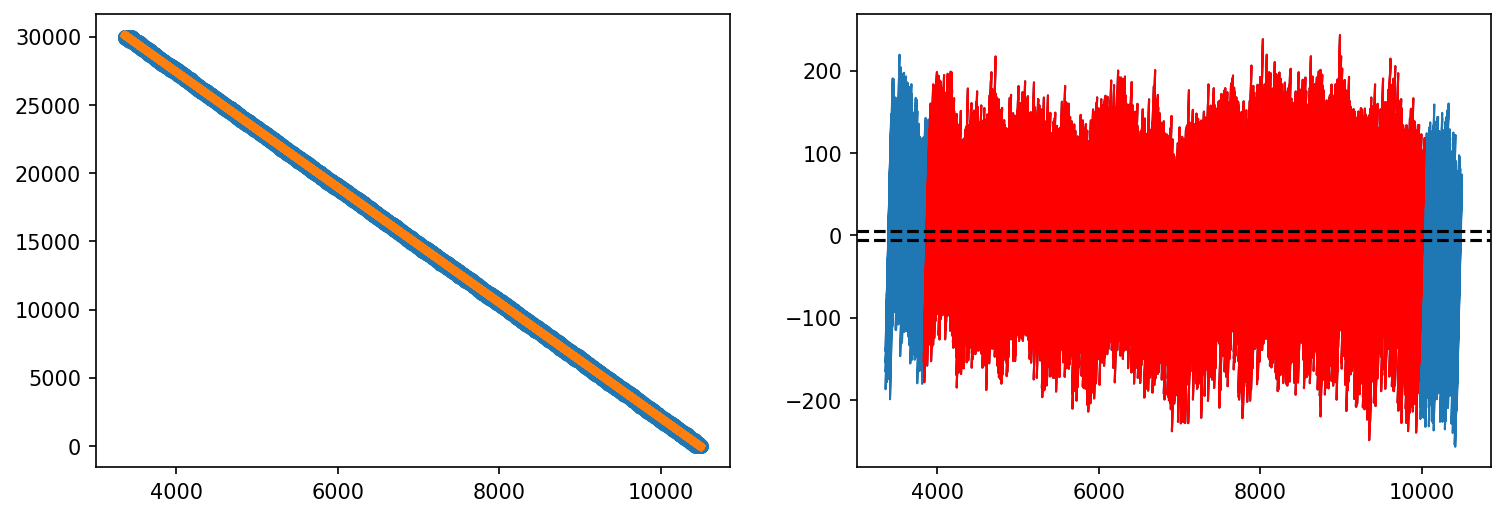

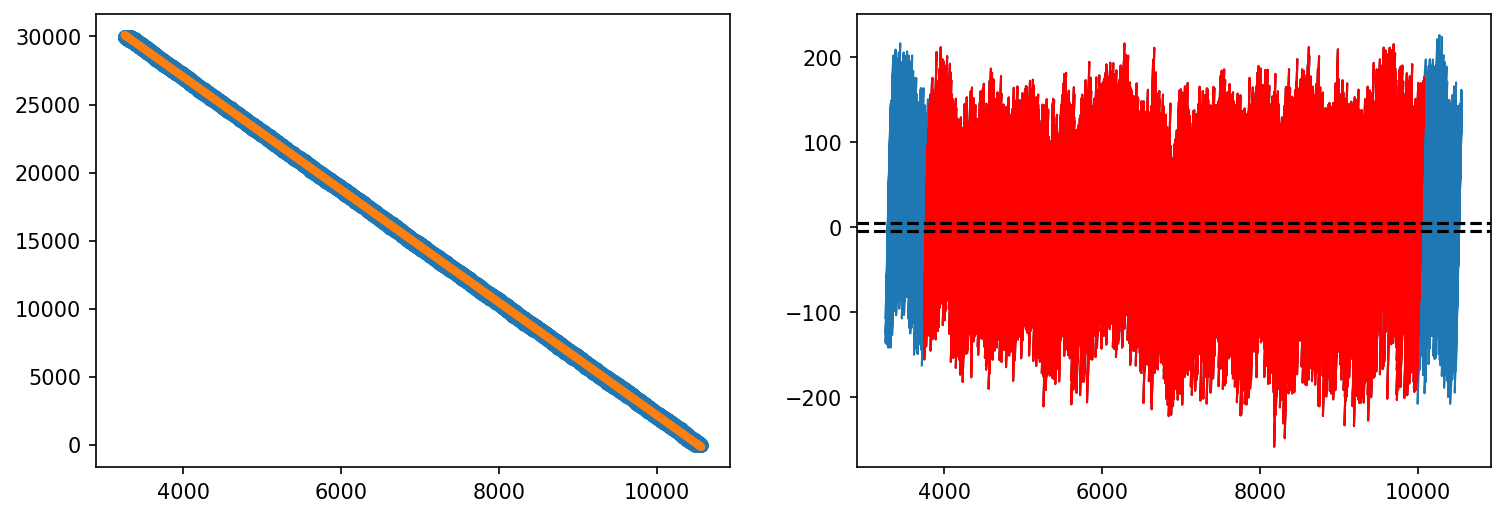

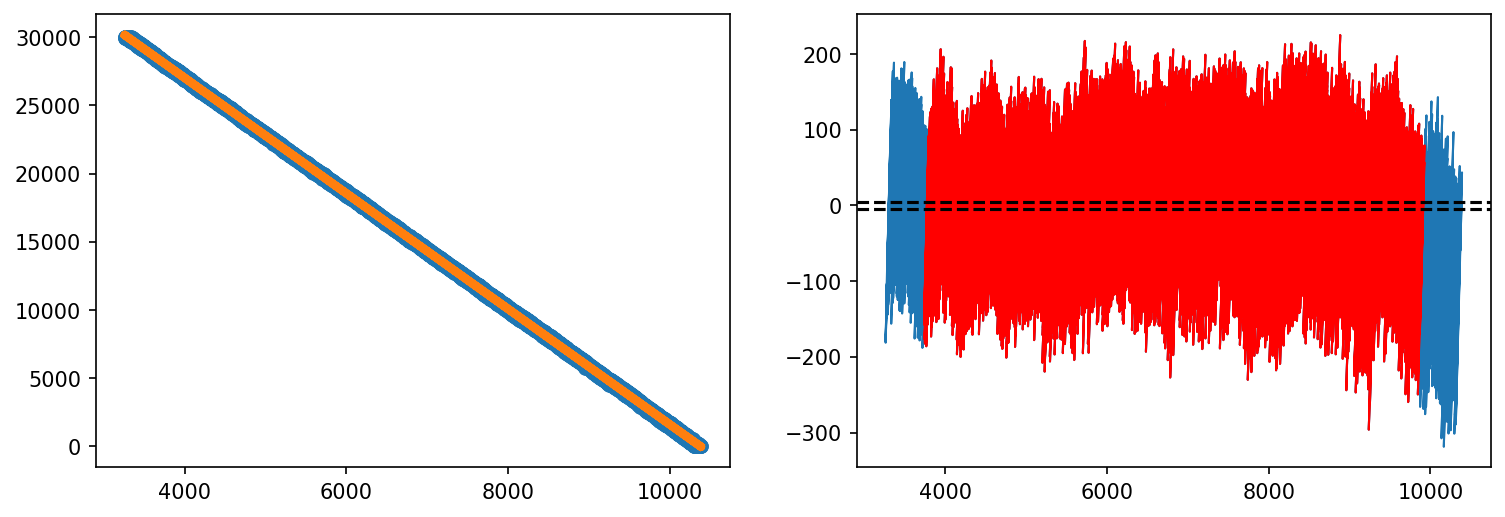

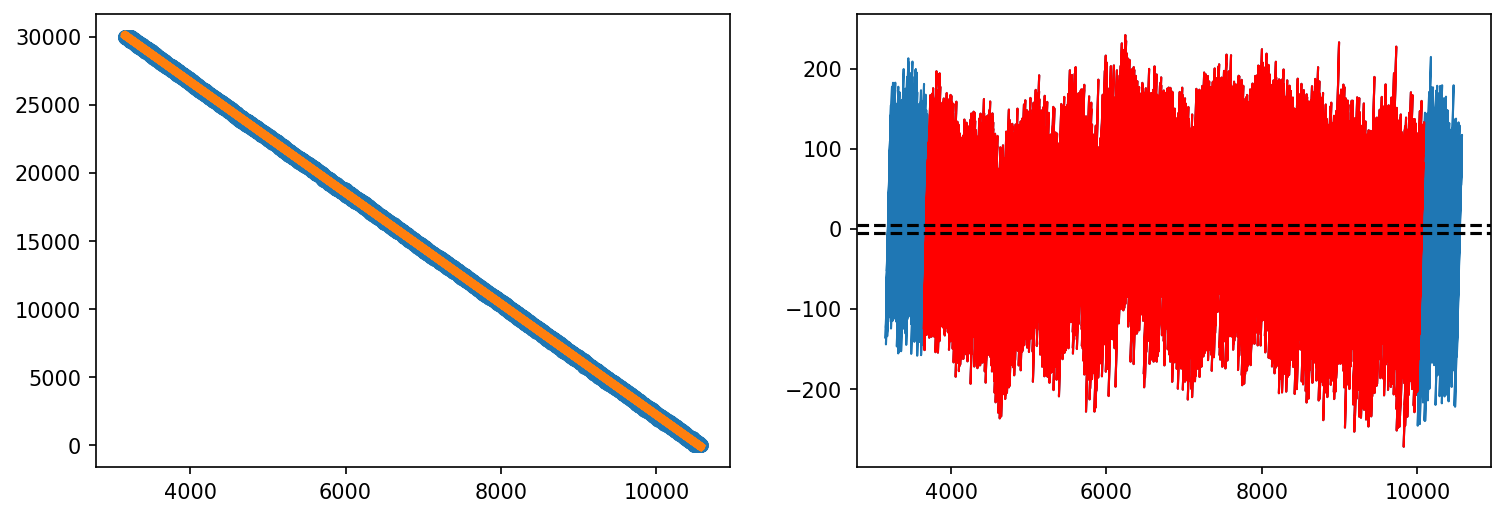

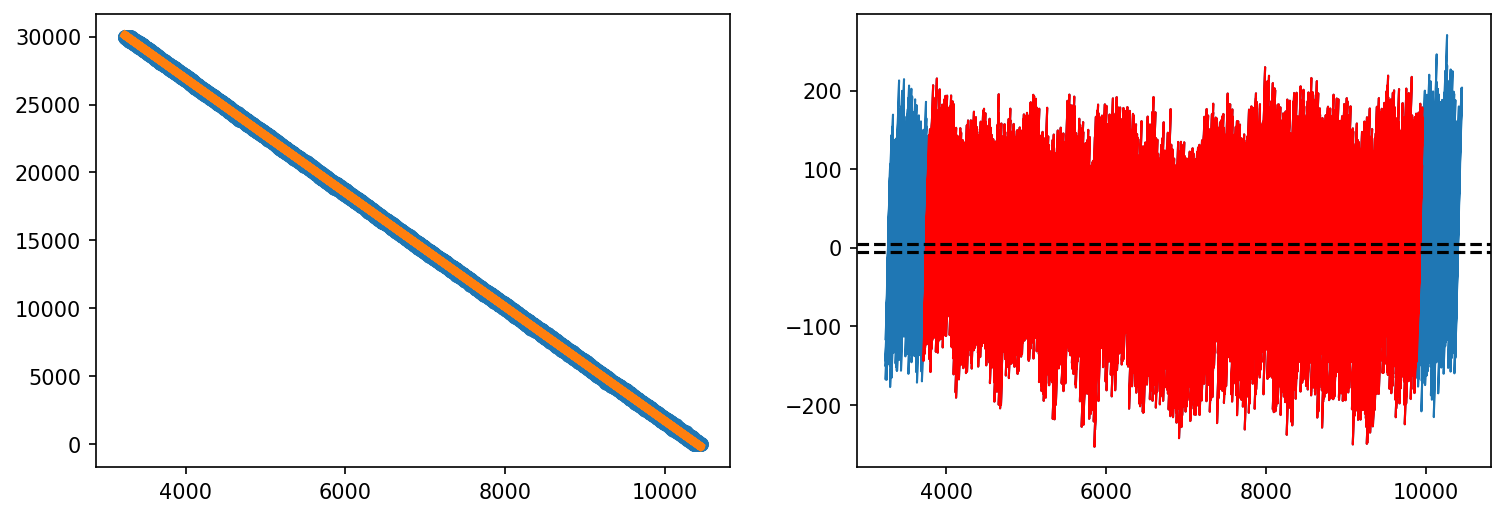

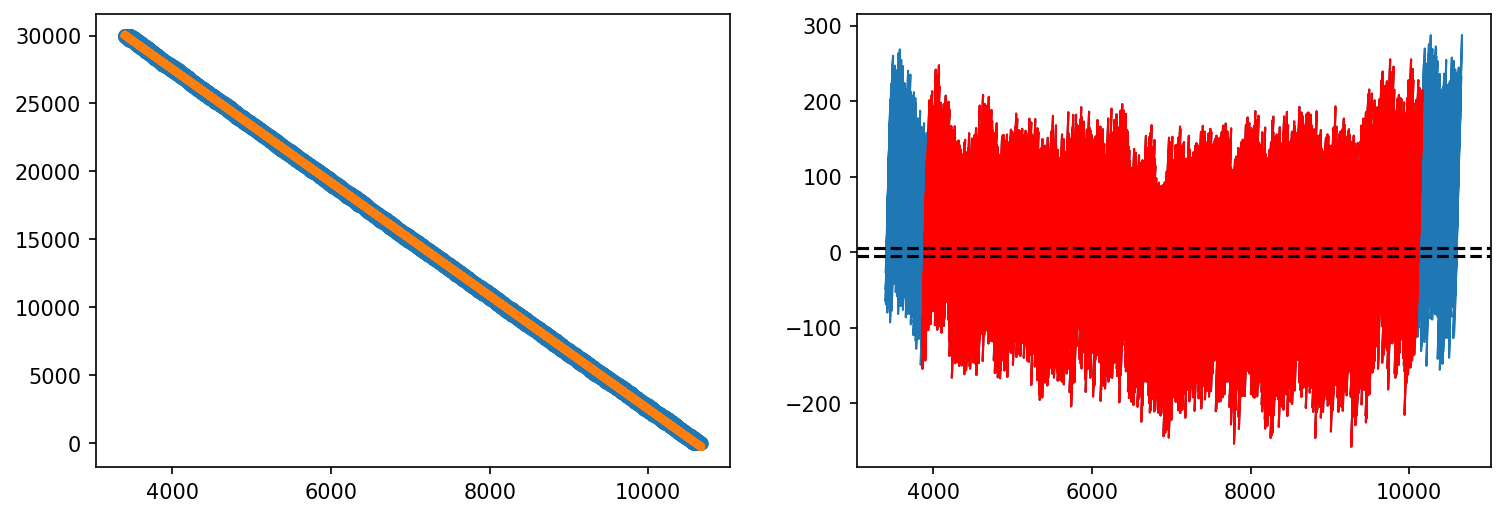

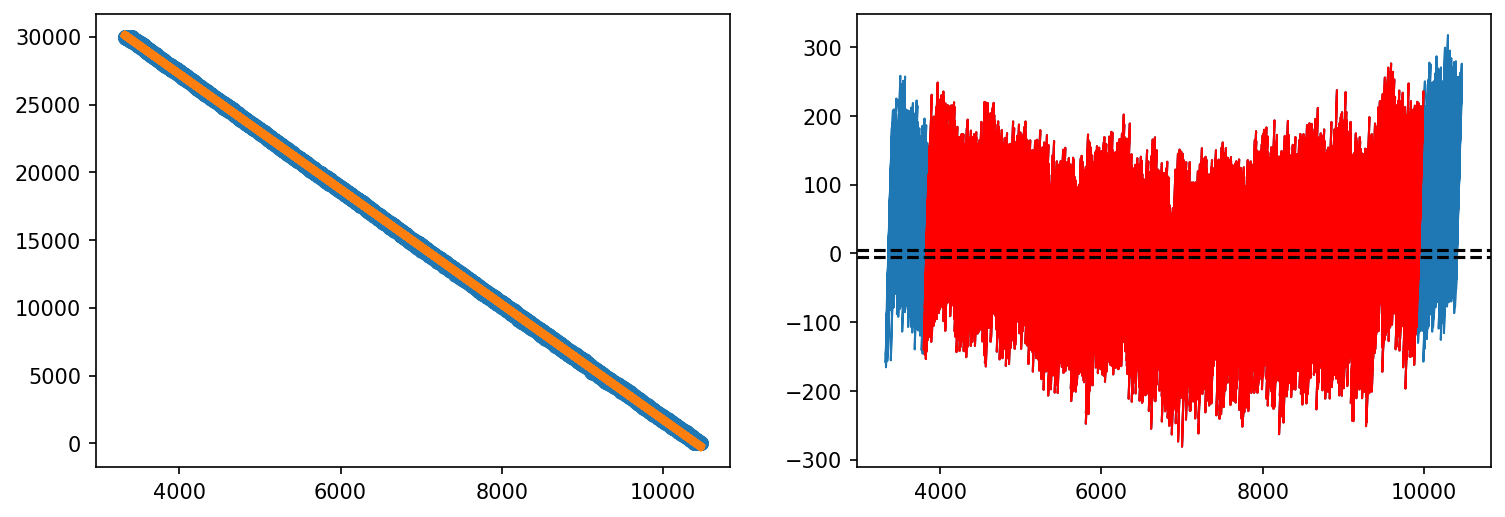

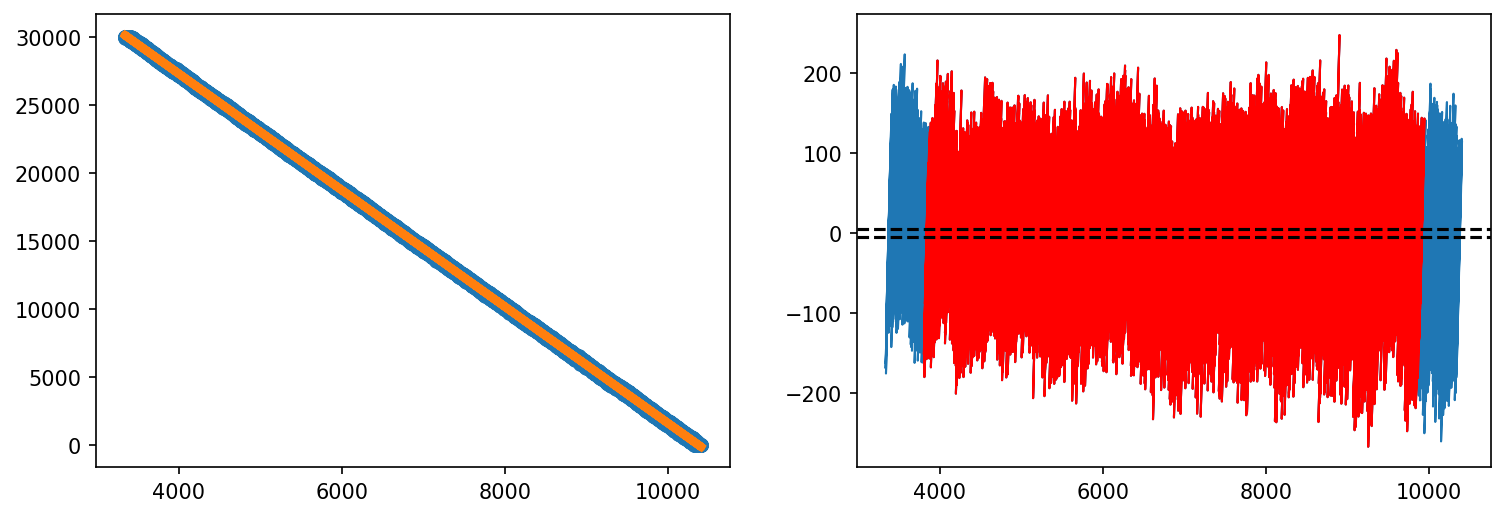

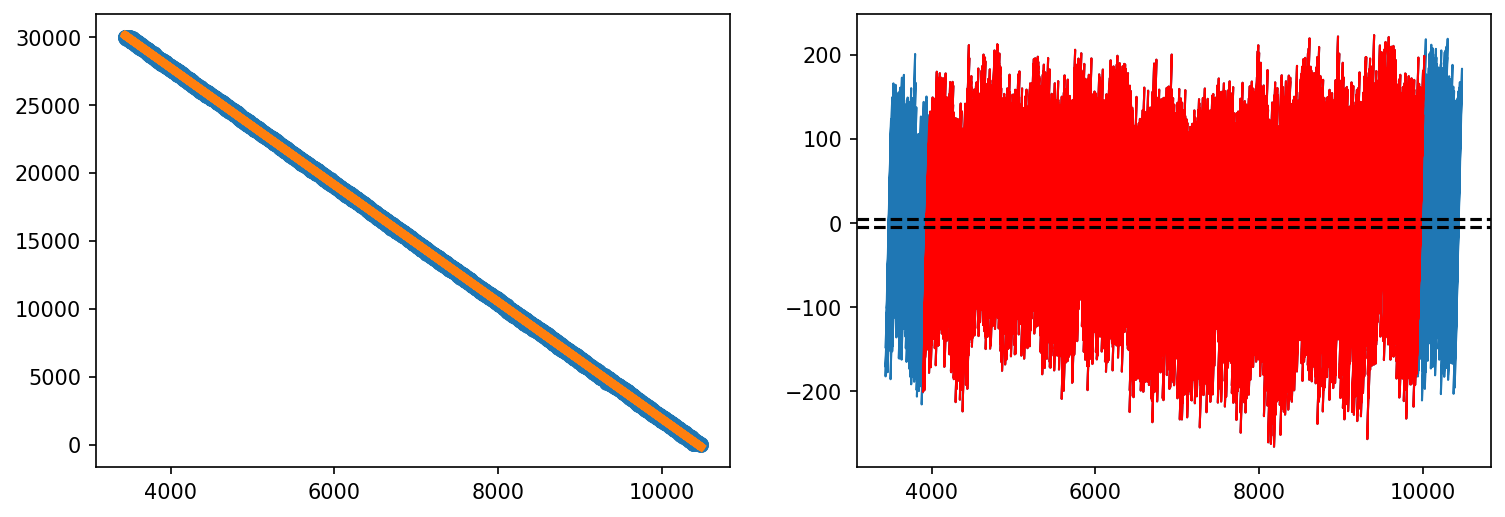

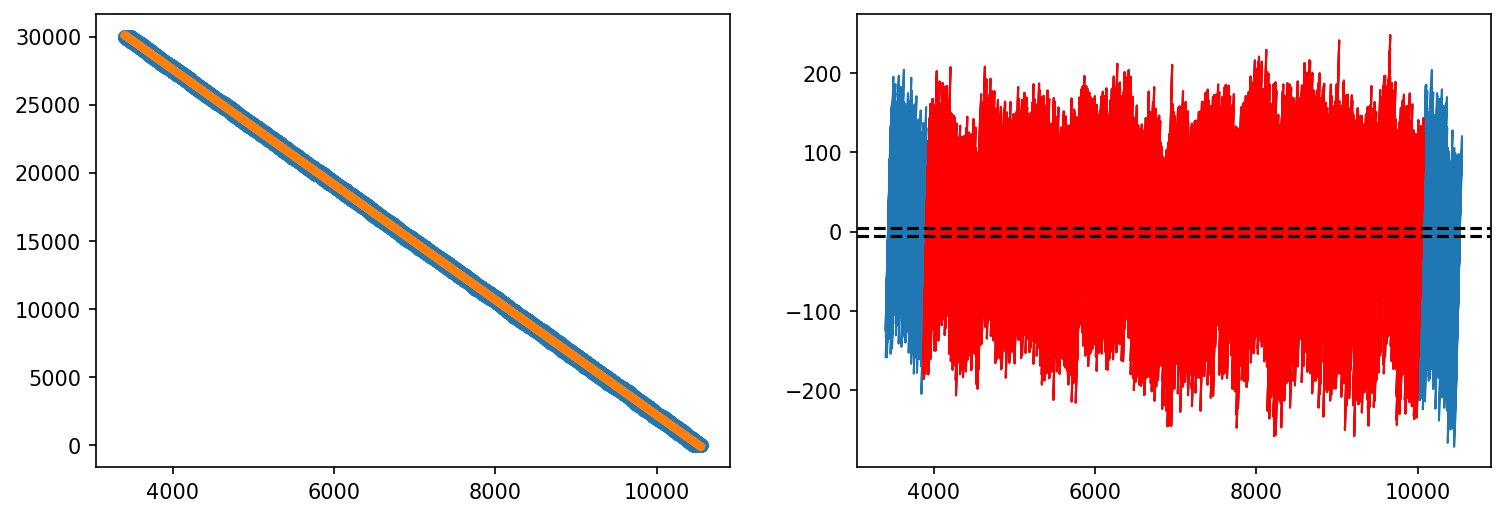

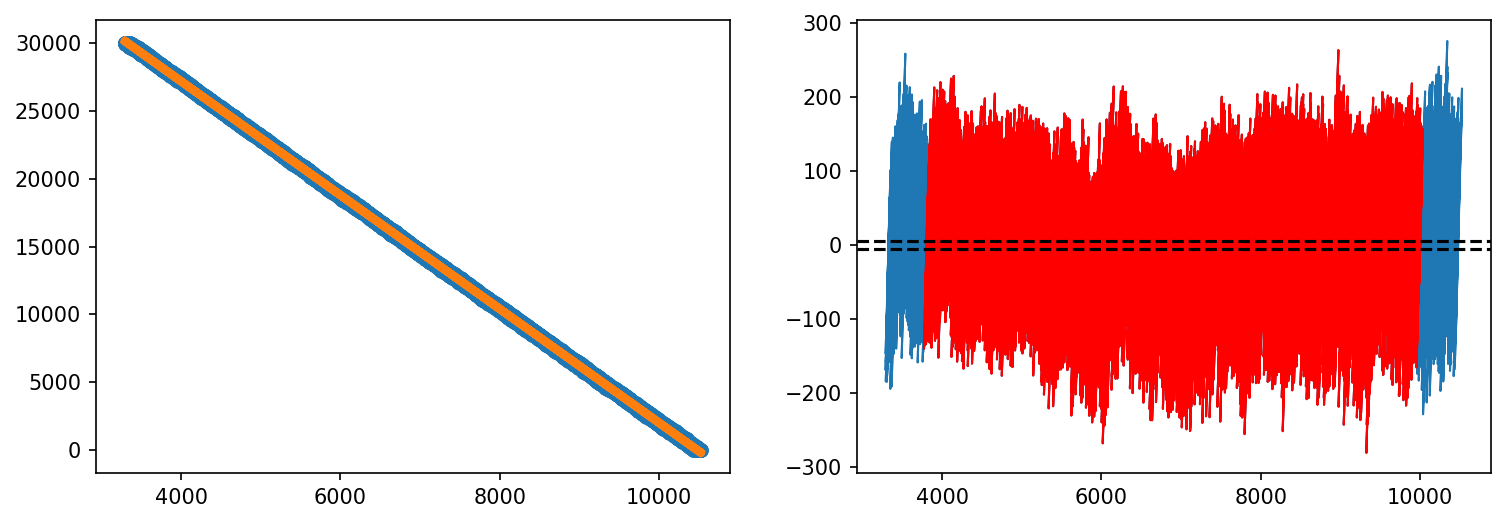

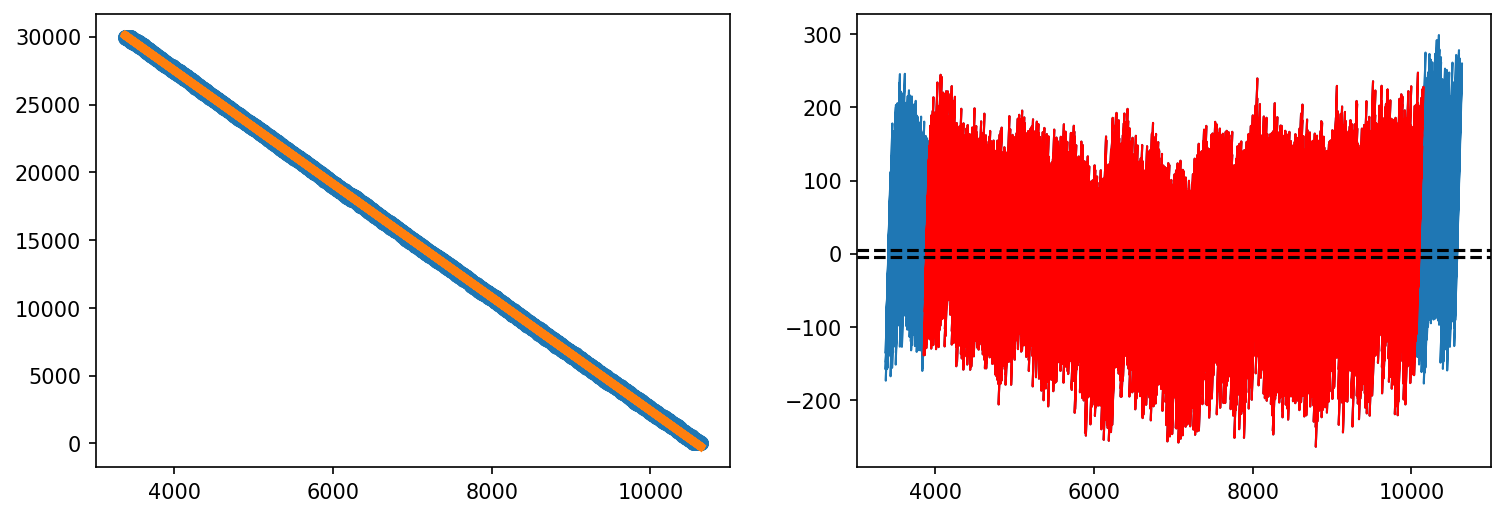

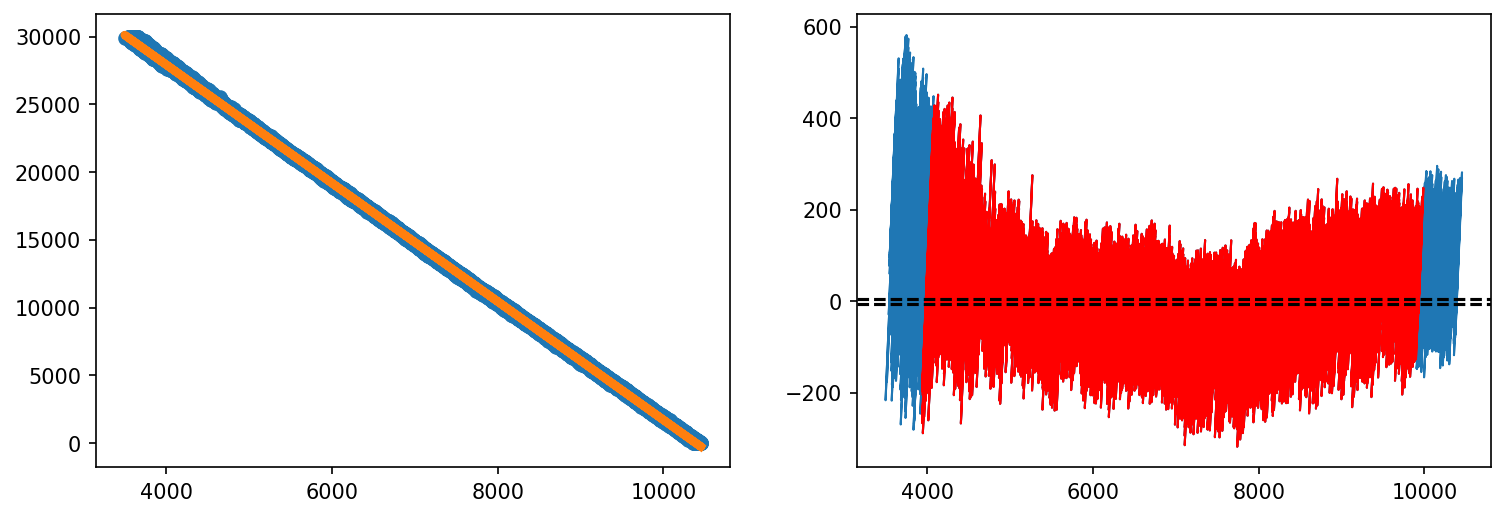

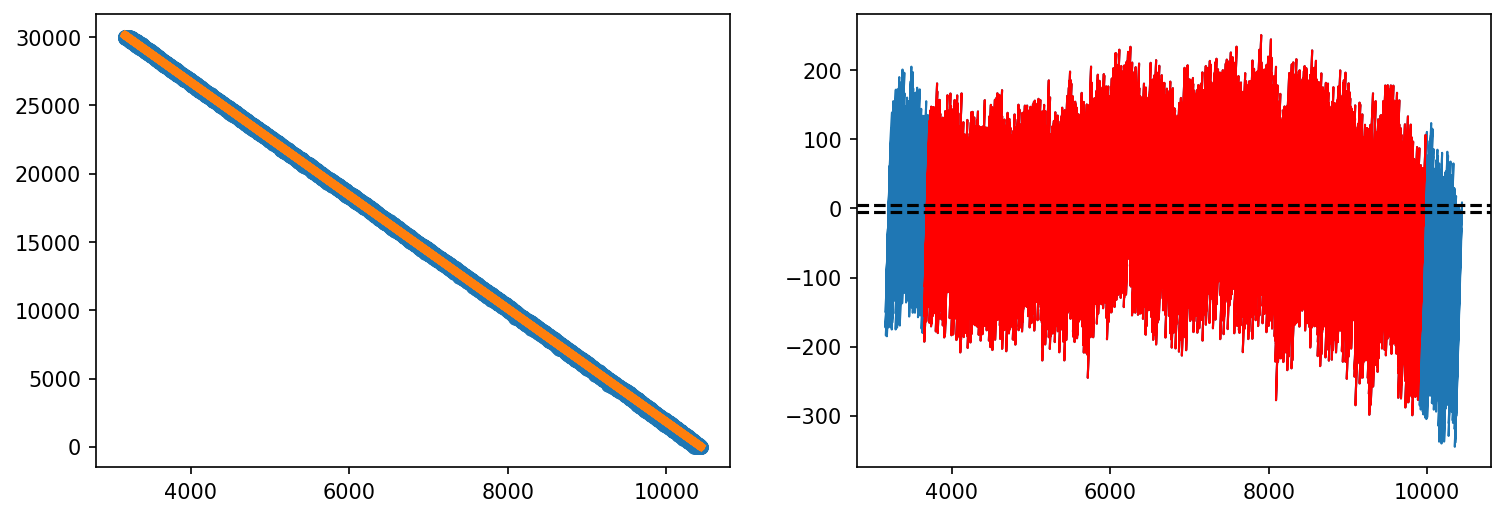

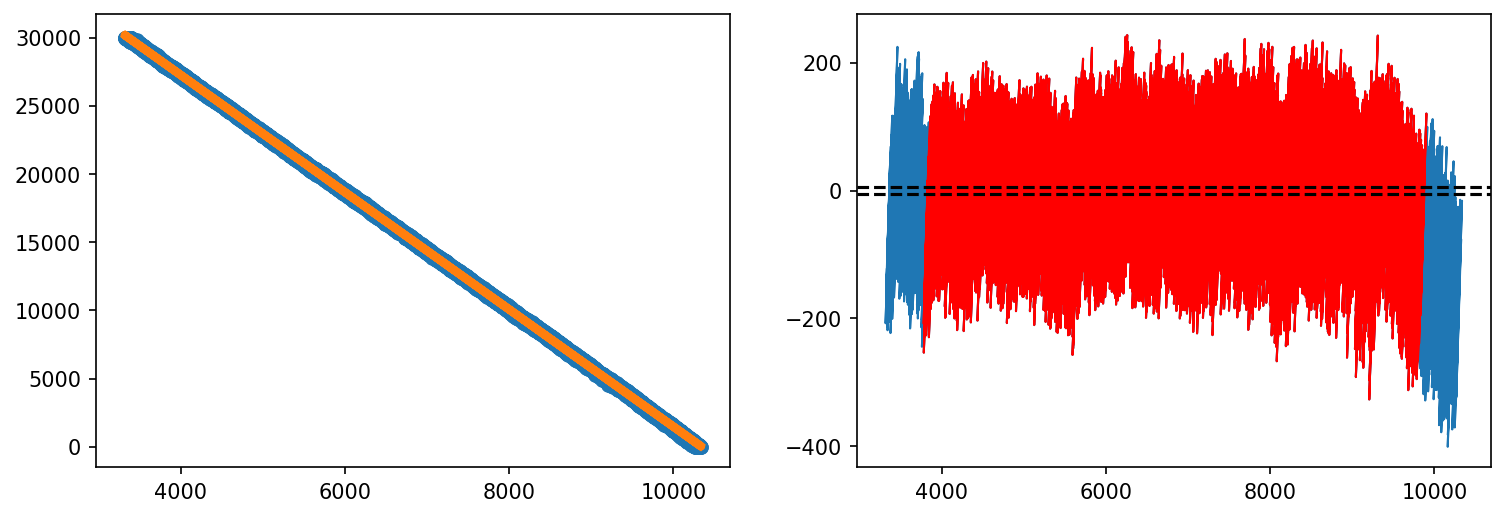

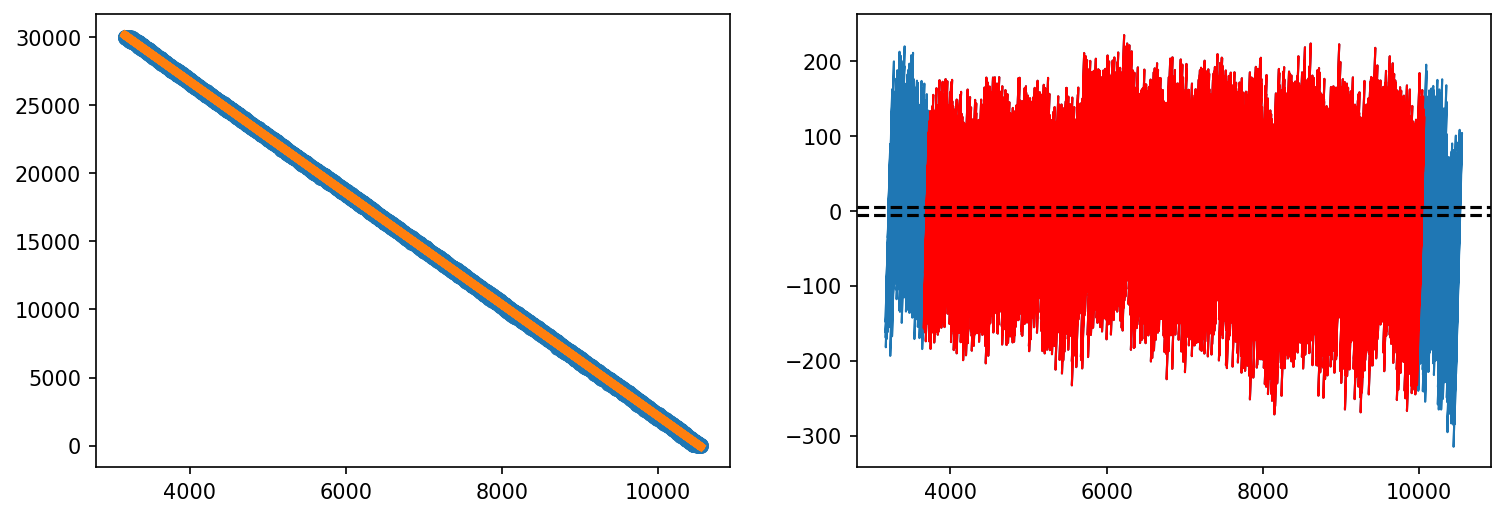

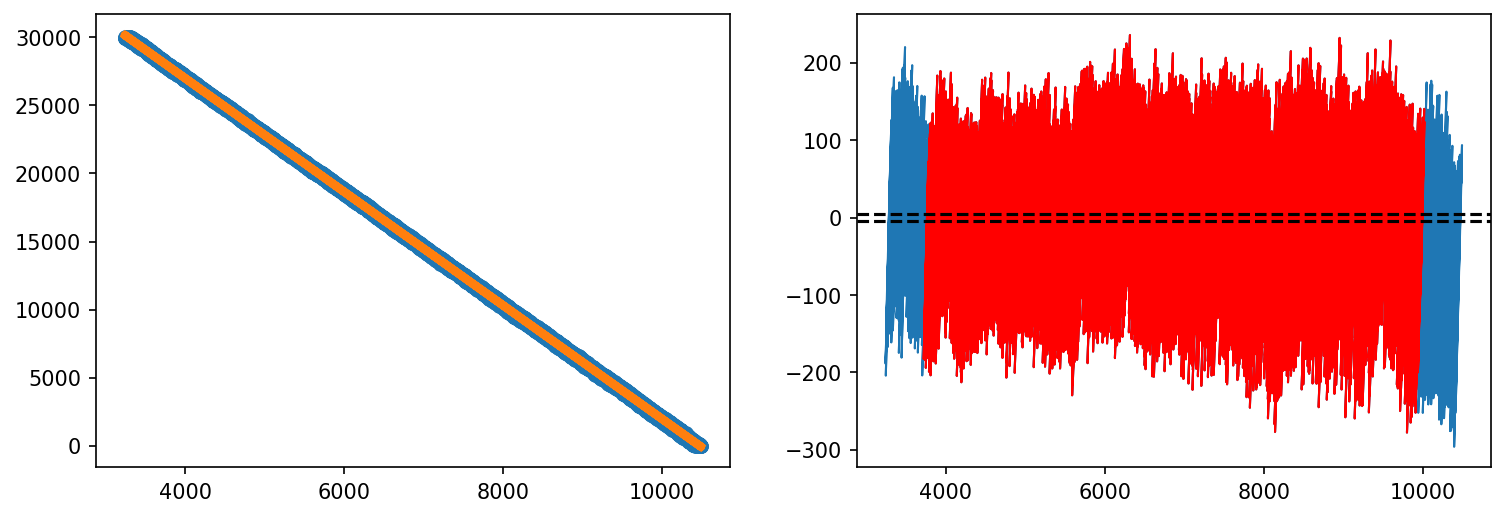

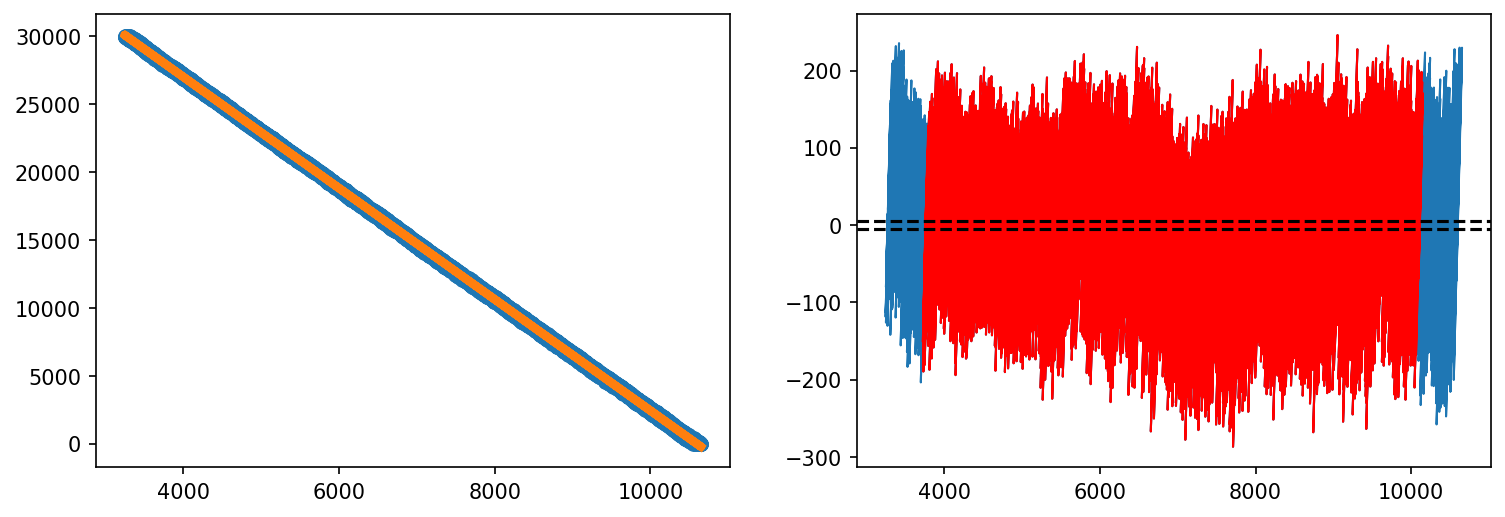

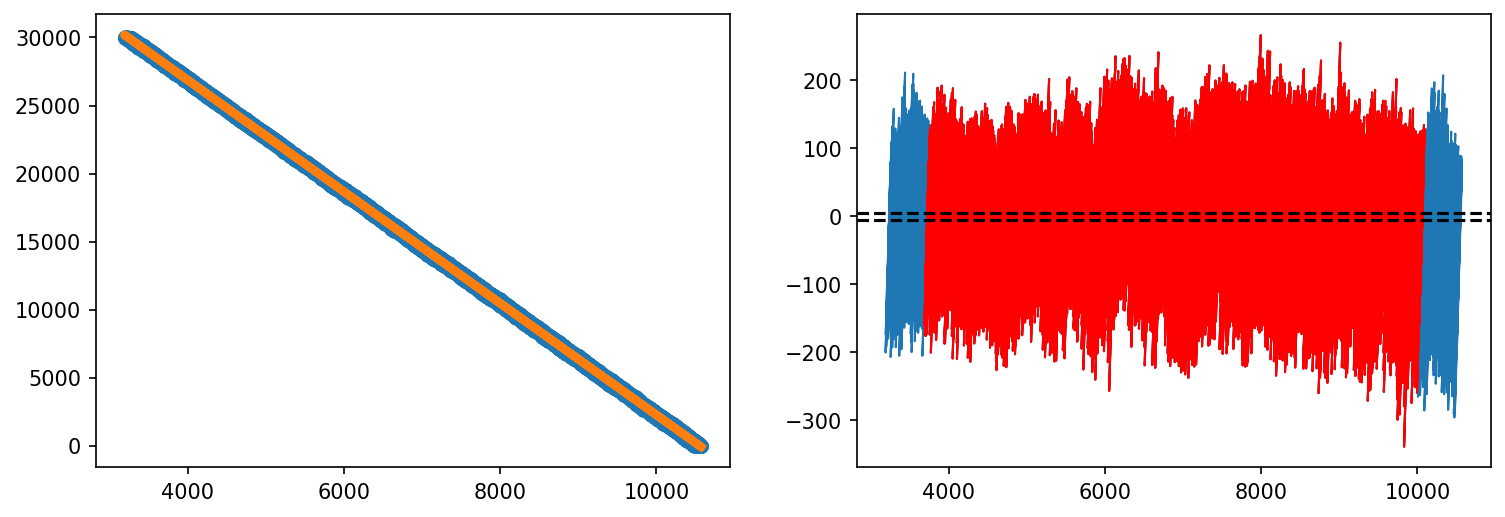

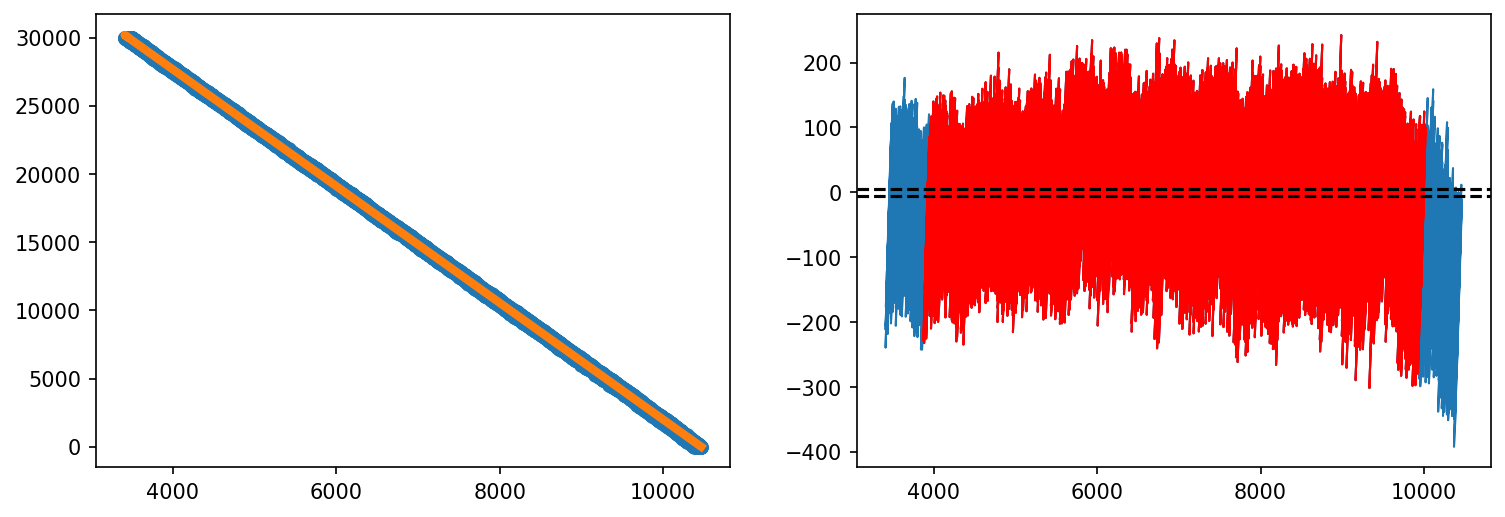

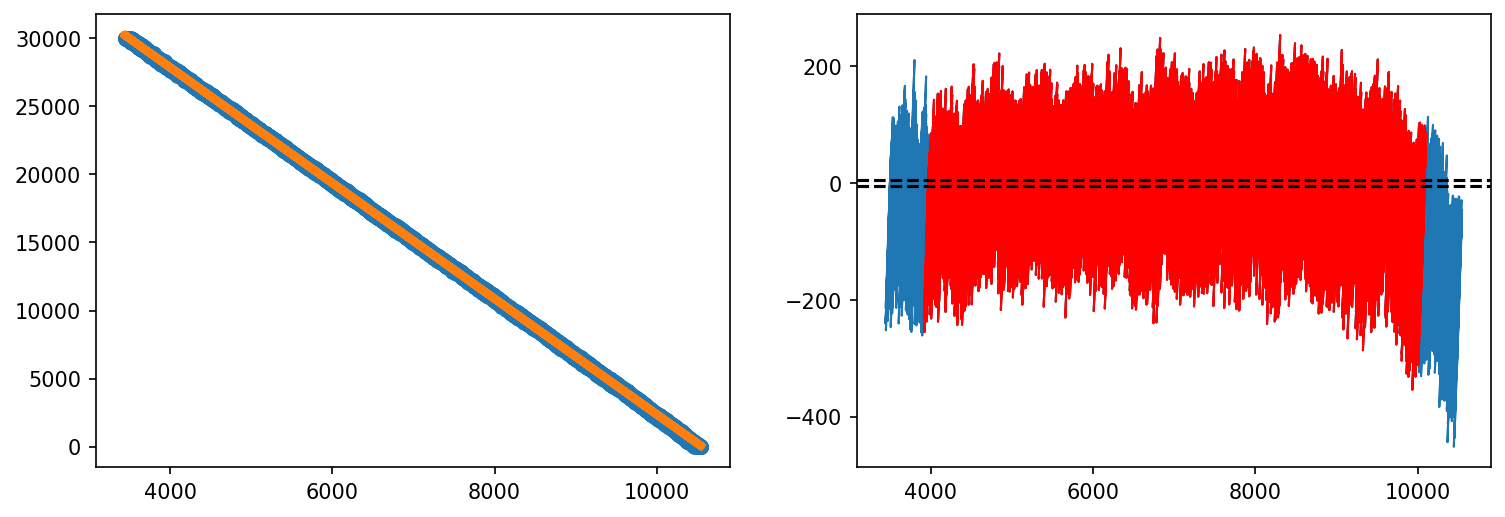

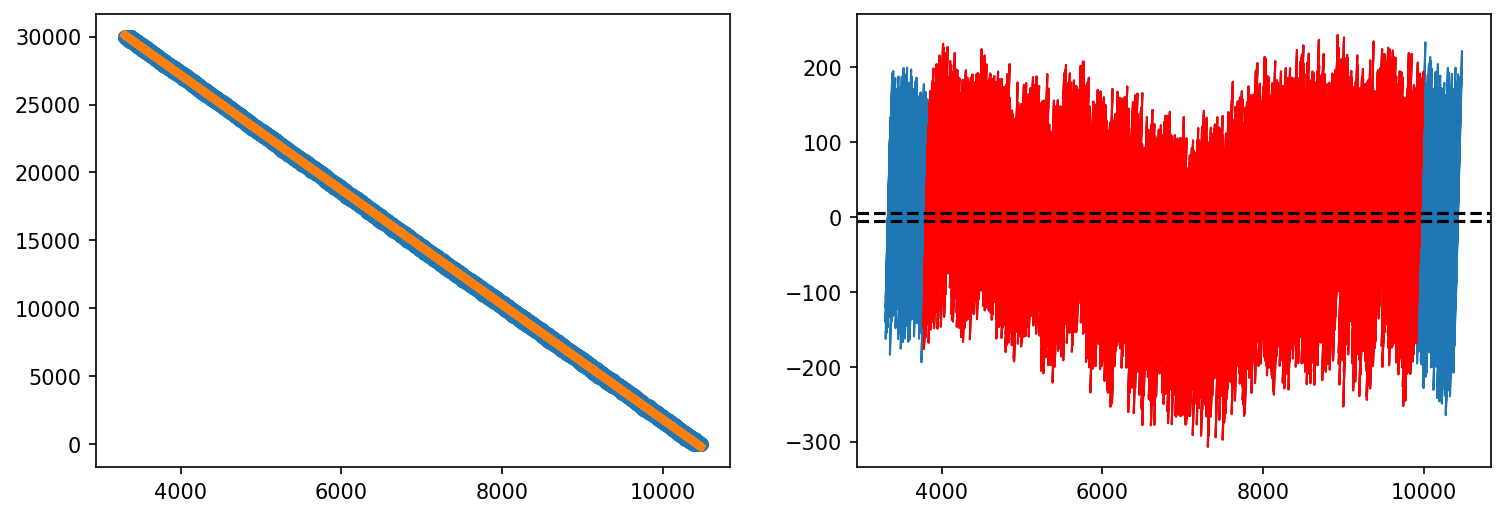

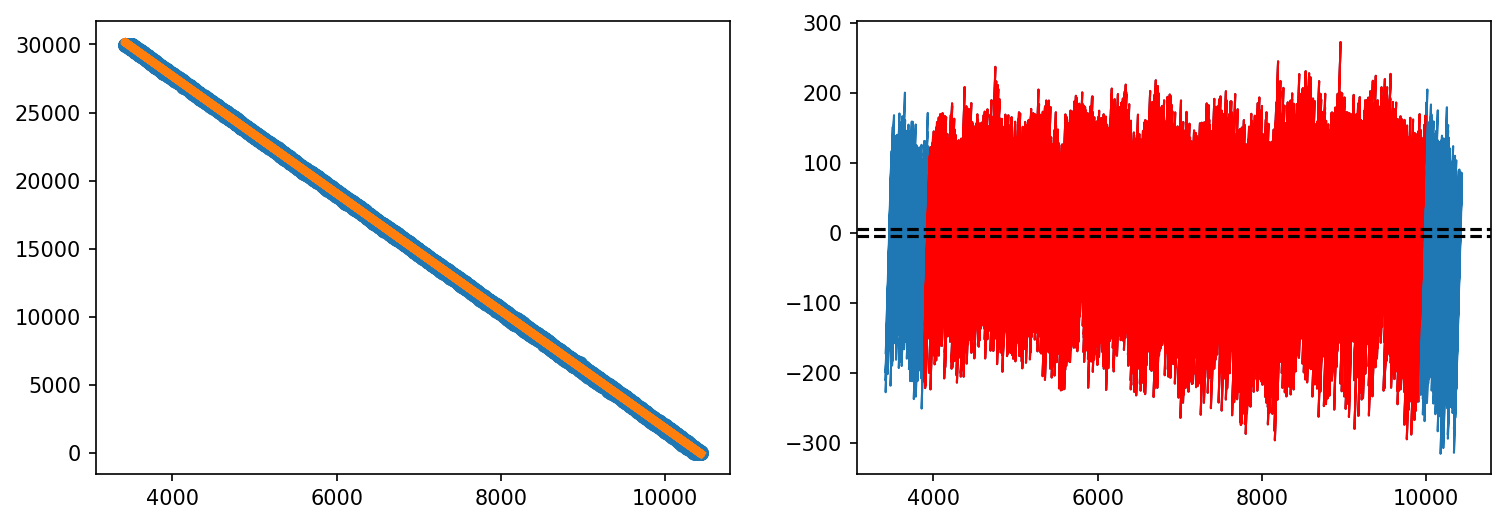

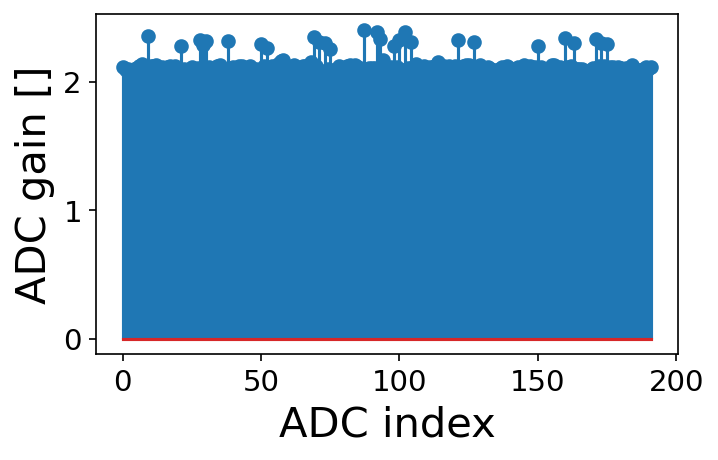

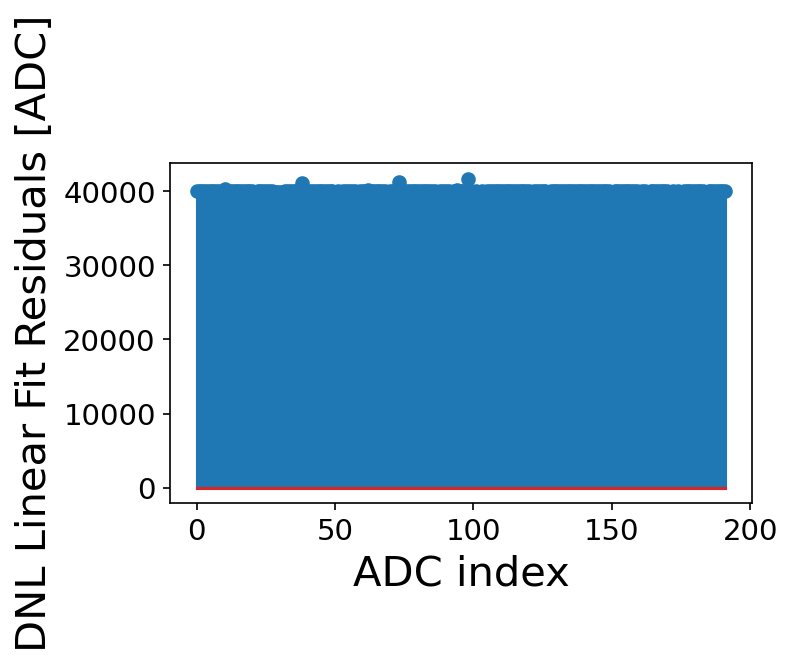

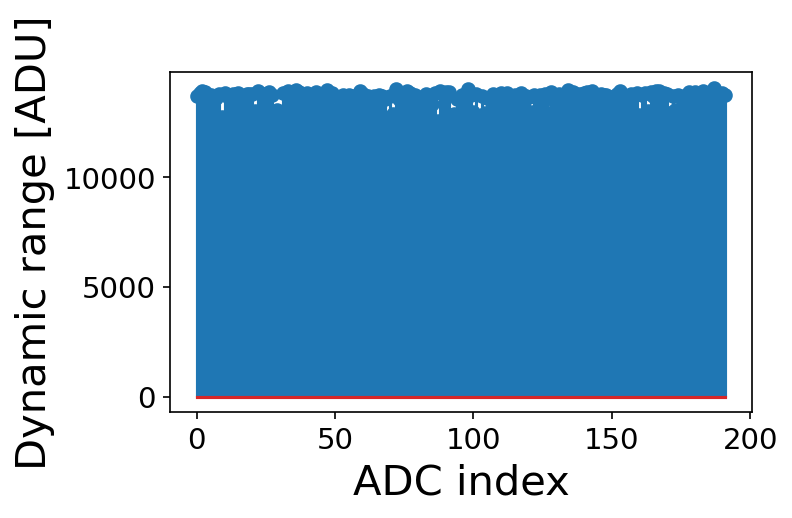

In [10]:
#
SCAN_STEP_C = 1
Preamp = 4
Vld1_b = 1
Pixel_CB= 4
Filter_DAC= 38
VRef_DAC = 53    

DHg = False

RefGenBList = [2]
RefGenC = 3
S2D_1_b = 0
shvc_DAC = 23
S2dDacBias = 3


for RefGenB in RefGenBList:
    filename = (filename_root + f'ePixHR10kT_ASIC2_V4_externalRamp_320MHz_ScanStep_%d_initSequence_%d_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_DHg_%d_RefGenB_%d_RefGenC_%d_run1.dat' % (SCAN_STEP_C,initSequence, Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC,DHg,RefGenB,RefGenC))
    h5_filename = os.path.splitext(filename)[0]+".hdf5"
    imgDesc, maxRange = externalRampTest_analyses_sept1(h5_filename)
    externalRampTest_analyses_sept2()
    externalRampTest_analyses_sept3()
    externalRampTest_analyses_sept4()
    CHANNEL_INDEX_CTE, gainList, measuredMaxDevLinFit, rangeList = externalRampTest_analyses_sept5()
    externalRampTest_analyses_sept6()
    

In [11]:
#
RefGenB = 2
RefGenCList = [3,2,1,0]
S2D_1_b = 0
shvc_DAC = 23
S2dDacBias = 3
for RefGenC in RefGenCList:
    filename = (filename_root + f'ePixHR10kT_ASIC2_V4_externalRamp_320MHz_ScanStep_10_initSequence_%d_RefGenB_%d_RefGenC_%d_S2D_1_b_%d_shvc_DAC_%d_S2dDacBias_%d_All_run1.dat' % (initSequence, RefGenB, RefGenC, S2D_1_b, shvc_DAC, S2dDacBias))
    h5_filename = os.path.splitext(filename)[0]+".hdf5"
    imgDesc, maxRange = externalRampTest_analyses_sept1(h5_filename)
    externalRampTest_analyses_sept2()
    externalRampTest_analyses_sept3()
    externalRampTest_analyses_sept4()
    CHANNEL_INDEX_CTE, gainList, measuredMaxDevLinFit, rangeList = externalRampTest_analyses_sept5()
    externalRampTest_analyses_sept6()
    

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/u2/ddoering/DET_HO1_V4_ASIC2_RUN_SET_1/ePixHR10kT_ASIC2_V4_externalRamp_320MHz_ScanStep_10_initSequence_5_RefGenB_2_RefGenC_3_S2D_1_b_0_shvc_DAC_23_S2dDacBias_3_All_run1.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
#
RefGenB = 3
RefGenC = 2
S2D_1_bList = [0,1,2,3,4,5,6,7]
shvc_DAC = 23
S2dDacBias = 3
for S2D_1_b in S2D_1_bList:
    filename = (filename_root + f'ePixHR10kT_ASIC3_V3_externalRamp_320MHz_ScanStep_10_RefGenB_%d_RefGenC_%d_S2D_1_b_%d_shvc_DAC_%d_S2dDacBias_%d_All_run1.dat' % (RefGenB, RefGenC, S2D_1_b, shvc_DAC, S2dDacBias))
    h5_filename = os.path.splitext(filename)[0]+".hdf5"
    imgDesc, maxRange = externalRampTest_analyses_sept1(h5_filename)
    externalRampTest_analyses_sept2()
    externalRampTest_analyses_sept3()
    externalRampTest_analyses_sept4()
    CHANNEL_INDEX_CTE, gainList, measuredMaxDevLinFit, rangeList = externalRampTest_analyses_sept5()
    externalRampTest_analyses_sept6()
    

In [ ]:
#
RefGenB = 3
RefGenC = 2
S2D_1_b = 0
shvc_DACList = [20,21,22,23,24,25,26,27]
S2dDacBias = 3
for shvc_DAC in shvc_DACList:
    filename = (filename_root + f'ePixHR10kT_ASIC3_V3_externalRamp_320MHz_ScanStep_10_RefGenB_%d_RefGenC_%d_S2D_1_b_%d_shvc_DAC_%d_S2dDacBias_%d_All_run1.dat' % (RefGenB, RefGenC, S2D_1_b, shvc_DAC, S2dDacBias))
    h5_filename = os.path.splitext(filename)[0]+".hdf5"
    imgDesc, maxRange = externalRampTest_analyses_sept1(h5_filename)
    externalRampTest_analyses_sept2()
    externalRampTest_analyses_sept3()
    externalRampTest_analyses_sept4()
    CHANNEL_INDEX_CTE, gainList, measuredMaxDevLinFit, rangeList = externalRampTest_analyses_sept5()
    externalRampTest_analyses_sept6()
    

In [ ]:
#
RefGenB = 3
RefGenC = 2
S2D_1_b = 0
shvc_DACList = [28,29,30,31,32,33,34,35]
S2dDacBias = 3
for shvc_DAC in shvc_DACList:
    filename = (filename_root + f'ePixHR10kT_ASIC3_V3_externalRamp_320MHz_ScanStep_10_RefGenB_%d_RefGenC_%d_S2D_1_b_%d_shvc_DAC_%d_S2dDacBias_%d_All_run1.dat' % (RefGenB, RefGenC, S2D_1_b, shvc_DAC, S2dDacBias))
    h5_filename = os.path.splitext(filename)[0]+".hdf5"
    imgDesc, maxRange = externalRampTest_analyses_sept1(h5_filename)
    externalRampTest_analyses_sept2()
    externalRampTest_analyses_sept3()
    externalRampTest_analyses_sept4()
    CHANNEL_INDEX_CTE, gainList, measuredMaxDevLinFit, rangeList = externalRampTest_analyses_sept5()
    externalRampTest_analyses_sept6()
    

In [ ]:
#
RefGenB = 3
RefGenC = 2
S2D_1_b = 0
shvc_DACList = [36,37,38,39,40,41,42,43]
S2dDacBias = 3
for shvc_DAC in shvc_DACList:
    filename = (filename_root + f'ePixHR10kT_ASIC3_V3_externalRamp_320MHz_ScanStep_10_RefGenB_%d_RefGenC_%d_S2D_1_b_%d_shvc_DAC_%d_S2dDacBias_%d_All_run1.dat' % (RefGenB, RefGenC, S2D_1_b, shvc_DAC, S2dDacBias))
    h5_filename = os.path.splitext(filename)[0]+".hdf5"
    imgDesc, maxRange = externalRampTest_analyses_sept1(h5_filename)
    externalRampTest_analyses_sept2()
    externalRampTest_analyses_sept3()
    externalRampTest_analyses_sept4()
    CHANNEL_INDEX_CTE, gainList, measuredMaxDevLinFit, rangeList = externalRampTest_analyses_sept5()
    externalRampTest_analyses_sept6()
    

In [ ]:
#
RefGenB = 3
RefGenC = 2
S2D_1_b = 0
shvc_DACList = [44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63]
S2dDacBias = 3
for shvc_DAC in shvc_DACList:
    filename = (filename_root + f'ePixHR10kT_ASIC3_V3_externalRamp_320MHz_ScanStep_10_RefGenB_%d_RefGenC_%d_S2D_1_b_%d_shvc_DAC_%d_S2dDacBias_%d_All_run1.dat' % (RefGenB, RefGenC, S2D_1_b, shvc_DAC, S2dDacBias))
    h5_filename = os.path.splitext(filename)[0]+".hdf5"
    imgDesc, maxRange = externalRampTest_analyses_sept1(h5_filename)
    externalRampTest_analyses_sept2()
    externalRampTest_analyses_sept3()
    externalRampTest_analyses_sept4()
    CHANNEL_INDEX_CTE, gainList, measuredMaxDevLinFit, rangeList = externalRampTest_analyses_sept5()
    externalRampTest_analyses_sept6()
    

In [ ]:
#
RefGenB = 3
RefGenC = 2
S2D_1_b = 0
shvc_DAC = 23
S2dDacBiasList = [3,2,1,0]
for S2dDacBias in S2dDacBiasList:
    filename = (filename_root + f'ePixHR10kT_ASIC3_V3_externalRamp_320MHz_ScanStep_10_RefGenB_%d_RefGenC_%d_S2D_1_b_%d_shvc_DAC_%d_S2dDacBias_%d_All_run1.dat' % (RefGenB, RefGenC, S2D_1_b, shvc_DAC, S2dDacBias))
    h5_filename = os.path.splitext(filename)[0]+".hdf5"
    imgDesc, maxRange = externalRampTest_analyses_sept1(h5_filename)
    externalRampTest_analyses_sept2()
    externalRampTest_analyses_sept3()
    externalRampTest_analyses_sept4()
    CHANNEL_INDEX_CTE, gainList, measuredMaxDevLinFit, rangeList = externalRampTest_analyses_sept5()
    externalRampTest_analyses_sept6()
    

Test completed

In [ ]:
whos